TODO:
    
    - Save cube

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm, Normalize, ListedColormap, LogNorm
from matplotlib import colors
from matplotlib import colormaps
from matplotlib import cm
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd

from astropy.io import ascii, fits
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.coordinates import SkyCoord, concatenate
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.nddata import Cutout2D
import astropy.constants as const

from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture

from scipy.ndimage import rotate, gaussian_filter
from scipy.optimize import minimize, minimize_scalar
from scipy.integrate import quad

from itertools import product

from datetime import datetime
now = datetime.now().strftime("%y%m%d-%H%M%S")
hour = datetime.now().strftime("%y%m%d-%H")
today = datetime.now().strftime("%y%m%d")

from bowpy import bsmodels as bs
from bowpy import utils as ut
# from bowpy import bsutils as bu

%load_ext autoreload
%autoreload 2

In [2]:
cubes = {}
hdrs = {}
beamareas = {}
velchans = {}
chanwidths = {}
wcss = {}

In [3]:
rk = "bs1"
ps = { 
 "modelname": f"{rk}_{now}",
 'rj': 0.00,
 'L0': (0.5 * 300 * u.au).to(u.km).value,   
 'zj': (7.31 * 300 * u.au).to(u.km).value,
 'vj': 108,
 'vw': 0,   
 'v0': 17.,
 'rbf_obs': None,
# 'rbf_obs': (1 * 300 * u.au).to(u.km).value,
 'mass': 0.00031,   
}

psobs = { 
 'i': 20 * np.pi / 180,
 'vsys': 0,
 'distpc': 300,
 "nzs": 200,
}

bsm = bs.NJ(ps)

In [4]:
(bsm.mp0 * (u.solMass/u.s)).to(u.solMass/u.yr)

<Quantity 2.12777404e-06 solMass / yr>

In [5]:
(bsm.rhow * u.solMass/u.km**3).to(u.g/u.cm**3)

<Quantity 3.70567135e-19 g / cm3>

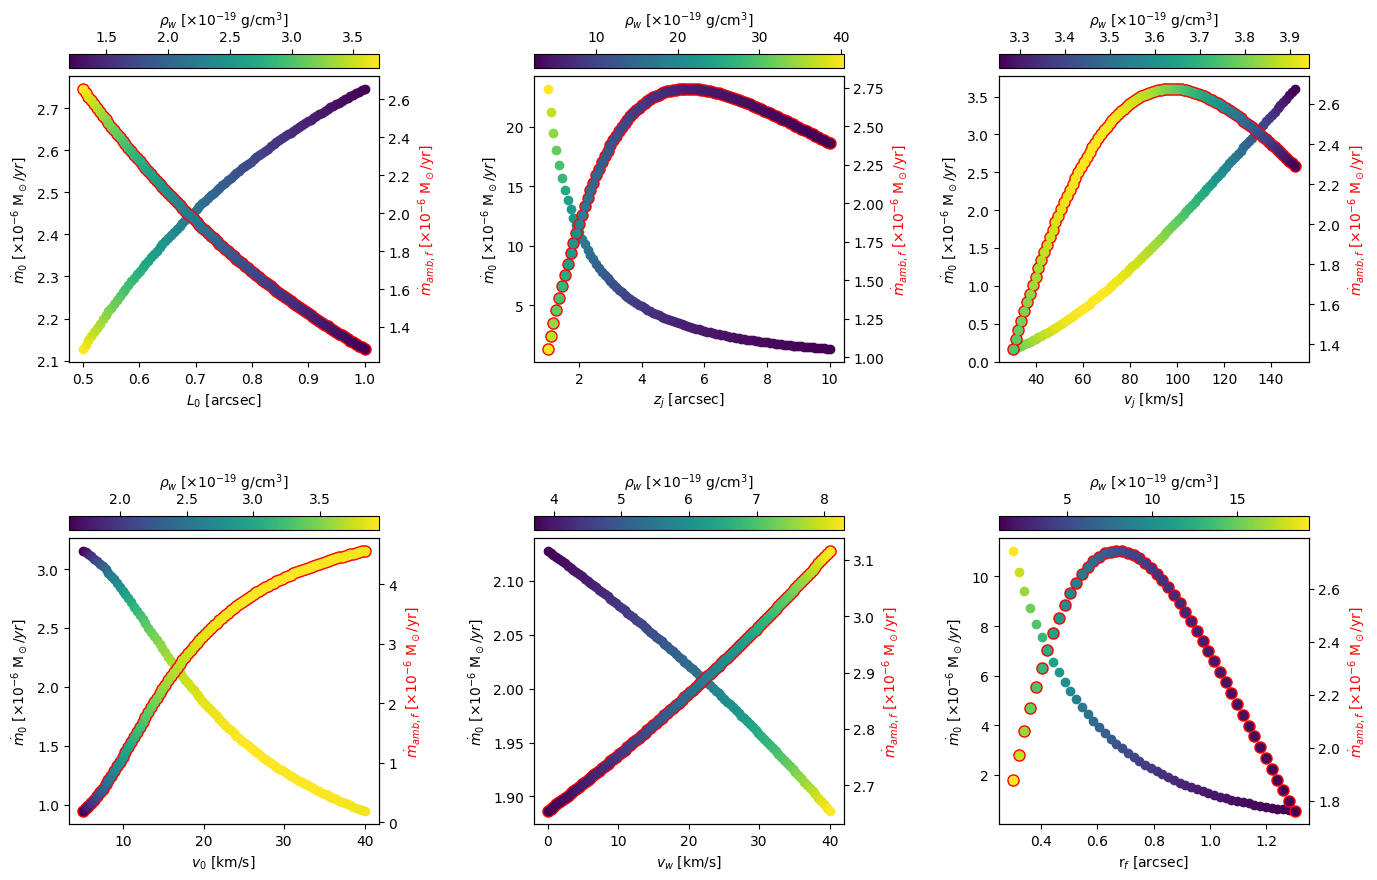

In [6]:
distpc = 300
varvalues = {
    "L0": np.linspace(0.5, 1, 100) * distpc * u.au.to(u.km),
    "zj": np.linspace(1, 10, 100) * distpc * u.au.to(u.km),
    "vj": np.linspace(30, 150, 100),
    "vw": np.linspace(0, 40, 100),
    "v0": np.linspace(5, 40, 100),
    "rbf_obs": np.linspace(0.3, 1.3) * distpc * u.au.to(u.km)
}

rhowfactor = 10**19
mp0sfactor = 10**6
mpambsfactor = 10**6

plt.figure(figsize=(16, 16))

gss = {}
axs1 = {}   
axs2 = {}   
cbaxs = {}
nrow = 3
ncol = 3
gs = GridSpec(
    nrow, ncol, 
    height_ratios=[1]*nrow,
    width_ratios=[1]*ncol,
    hspace=0.5,
    wspace=0.5,
)

kv = "L0"
rhows = []
mp0s = []
mpambs = []
for v in varvalues[kv]: 
    ps_copy = ps.copy()
    ps_copy[kv] = v
    bsm = bs.NJ(ps_copy)
    rhows.append(bsm.rhow*(u.solMass/(u.km**3)).to(u.g/u.cm**3)*rhowfactor)
    mp0s.append(bsm.mp0*(u.solMass/u.s).to(u.solMass/u.yr)*mp0sfactor)
    mpambs.append(bsm.mpamb_f*(u.solMass/u.s).to(u.solMass/u.yr)*mpambsfactor)

gss[kv] = gs[0, 0].subgridspec(
    2, 1,
    height_ratios=[0.05, 1],
    width_ratios=[1],
    hspace=0.05,
)
axs1[kv] = plt.subplot(gss[kv][1,0])
axs2[kv] = axs1[kv].twinx()
cbaxs[kv] = plt.subplot(gss[kv][0,0])
for i, rhow in enumerate(rhows):
    c = ut.get_color(
        [np.min(rhows), np.max(rhows)],
        rhow,
        "viridis",
    )
    axs1[kv].plot(
        varvalues[kv][i]/(distpc*u.au.to(u.km)),
        mp0s[i],
        color=c,
        marker="o",
    )
    axs2[kv].plot(
        varvalues[kv][i]/(distpc*u.au.to(u.km)),
        mpambs[i],
        color=c,
        marker="o",
        markerfacecolor="none",
        markeredgecolor="r",
        zorder=-1,
        markeredgewidth=3,
    )      
    axs2[kv].plot(
        varvalues[kv][i]/(distpc*u.au.to(u.km)),
        mpambs[i],
        color=c,
        marker="o",
    )
cbar = plt.colorbar(
       cm.ScalarMappable(
           norm=colors.Normalize(
               vmax=np.max(rhows),
               vmin=np.min(rhows)),
           cmap="viridis",
       ),
       cax=cbaxs[kv],
       orientation="horizontal",
)
cbaxs[kv].tick_params(
    bottom=False, labelbottom=False,
    top=True, labeltop=True
)
axs1[kv].set_xlabel(r"$L_0$ [arcsec]")
axs1[kv].set_ylabel(r"$\dot{m}_0$ [$\times10^{-6}$ M$_\odot/yr$]")
axs2[kv].set_ylabel(r"$\dot{m}_{amb,f}$ [$\times10^{-6}$ M$_\odot$/yr]", color="r")
cbaxs[kv].set_xlabel(r"$\rho_w$ [$\times 10^{-19}$ g/cm$^3$]", )
cbaxs[kv].xaxis.set_label_position('top') 


kv = "zj"
rhows = []
mp0s = []
mpambs = []
for v in varvalues[kv]: 
    ps_copy = ps.copy()
    ps_copy[kv] = v
    bsm = bs.NJ(ps_copy)
    rhows.append(bsm.rhow*(u.solMass/(u.km**3)).to(u.g/u.cm**3)*rhowfactor)
    mp0s.append(bsm.mp0*(u.solMass/u.s).to(u.solMass/u.yr)*mp0sfactor)
    mpambs.append(bsm.mpamb_f*(u.solMass/u.s).to(u.solMass/u.yr)*mpambsfactor)

gss[kv] = gs[0, 1].subgridspec(
    2, 1,
    height_ratios=[0.05, 1],
    width_ratios=[1],
    hspace=0.05,
)
axs1[kv] = plt.subplot(gss[kv][1,0])
axs2[kv] = axs1[kv].twinx()
cbaxs[kv] = plt.subplot(gss[kv][0,0])
for i, rhow in enumerate(rhows):
    c = ut.get_color(
        [np.min(rhows), np.max(rhows)],
        rhow,
        "viridis",
    )
    axs1[kv].plot(
        varvalues[kv][i]/(distpc*u.au.to(u.km)),
        mp0s[i],
        color=c,
        marker="o",
    )
    axs2[kv].plot(
        varvalues[kv][i]/(distpc*u.au.to(u.km)),
        mpambs[i],
        color=c,
        marker="o",
        markerfacecolor="none",
        markeredgecolor="r",
        zorder=-1,
        markeredgewidth=3,
    )         
    axs2[kv].plot(
        varvalues[kv][i]/(distpc*u.au.to(u.km)),
        mpambs[i],
        color=c,
        marker="o",
    )
cbar = plt.colorbar(
       cm.ScalarMappable(
           norm=colors.Normalize(
               vmax=np.max(rhows),
               vmin=np.min(rhows)),
           cmap="viridis",
       ),
       cax=cbaxs[kv],
       orientation="horizontal",
)
cbaxs[kv].tick_params(
    bottom=False, labelbottom=False,
    top=True, labeltop=True
)
axs1[kv].set_xlabel(r"$z_j$ [arcsec]")
axs1[kv].set_ylabel(r"$\dot{m}_0$ [$\times10^{-6}$ M$_\odot/yr$]")
axs2[kv].set_ylabel(r"$\dot{m}_{amb,f}$ [$\times10^{-6}$ M$_\odot$/yr]", color="r")
cbaxs[kv].set_xlabel(r"$\rho_w$ [$\times$10$^{-19}$ g/cm$^3$]", )
cbaxs[kv].xaxis.set_label_position('top') 


kv = "vj"
rhows = []
mp0s = []
mpambs = []
for v in varvalues[kv]: 
    ps_copy = ps.copy()
    ps_copy[kv] = v
    bsm = bs.NJ(ps_copy)
    rhows.append(bsm.rhow*(u.solMass/(u.km**3)).to(u.g/u.cm**3)*rhowfactor)
    mp0s.append(bsm.mp0*(u.solMass/u.s).to(u.solMass/u.yr)*mp0sfactor)
    mpambs.append(bsm.mpamb_f*(u.solMass/u.s).to(u.solMass/u.yr)*mpambsfactor)

gss[kv] = gs[0, 2].subgridspec(
    2, 1,
    height_ratios=[0.05, 1],
    width_ratios=[1],
    hspace=0.05,
)
axs1[kv] = plt.subplot(gss[kv][1,0])
axs2[kv] = axs1[kv].twinx()
cbaxs[kv] = plt.subplot(gss[kv][0,0])
for i, rhow in enumerate(rhows):
    c = ut.get_color(
        [np.min(rhows), np.max(rhows)],
        rhow,
        "viridis",
    )
    axs1[kv].plot(
        varvalues[kv][i],
        mp0s[i],
        color=c,
        marker="o",
    )
    axs2[kv].plot(
        varvalues[kv][i],
        mpambs[i],
        color=c,
        marker="o",
        markerfacecolor="none",
        markeredgecolor="r",
        zorder=-1,
        markeredgewidth=3,
    )            
    axs2[kv].plot(
        varvalues[kv][i],
        mpambs[i],
        color=c,
        marker="o",
    )
cbar = plt.colorbar(
       cm.ScalarMappable(
           norm=colors.Normalize(
               vmax=np.max(rhows),
               vmin=np.min(rhows)),
           cmap="viridis",
       ),
       cax=cbaxs[kv],
       orientation="horizontal",
)
cbaxs[kv].tick_params(
    bottom=False, labelbottom=False,
    top=True, labeltop=True
)
axs1[kv].set_xlabel(r"$v_j$ [km/s]")
axs1[kv].set_ylabel(r"$\dot{m}_0$ [$\times10^{-6}$ M$_\odot/yr$]")
axs2[kv].set_ylabel(r"$\dot{m}_{amb,f}$ [$\times10^{-6}$ M$_\odot$/yr]", color="r")
cbaxs[kv].set_xlabel(r"$\rho_w$ [$\times$10$^{-19}$ g/cm$^3$]", )
cbaxs[kv].xaxis.set_label_position('top') 


kv = "v0"
rhows = []
mp0s = []
mpambs = []
for v in varvalues[kv]: 
    ps_copy = ps.copy()
    ps_copy[kv] = v
    bsm = bs.NJ(ps_copy)
    rhows.append(bsm.rhow*(u.solMass/(u.km**3)).to(u.g/u.cm**3)*rhowfactor)
    mp0s.append(bsm.mp0*(u.solMass/u.s).to(u.solMass/u.yr)*mp0sfactor)
    mpambs.append(bsm.mpamb_f*(u.solMass/u.s).to(u.solMass/u.yr)*mpambsfactor)

gss[kv] = gs[1, 0].subgridspec(
    2, 1,
    height_ratios=[0.05, 1],
    width_ratios=[1],
    hspace=0.05,
)
axs1[kv] = plt.subplot(gss[kv][1,0])
axs2[kv] = axs1[kv].twinx()
cbaxs[kv] = plt.subplot(gss[kv][0,0])
for i, rhow in enumerate(rhows):
    c = ut.get_color(
        [np.min(rhows), np.max(rhows)],
        rhow,
        "viridis",
    )
    axs1[kv].plot(
        varvalues[kv][i],
        mp0s[i],
        color=c,
        marker="o",
    )
    axs2[kv].plot(
        varvalues[kv][i],
        mpambs[i],
        color=c,
        marker="o",
        markerfacecolor="none",
        markeredgecolor="r",
        zorder=-1,
        markeredgewidth=3,
    )            
    axs2[kv].plot(
        varvalues[kv][i],
        mpambs[i],
        color=c,
        marker="o",
    )
cbar = plt.colorbar(
       cm.ScalarMappable(
           norm=colors.Normalize(
               vmax=np.max(rhows),
               vmin=np.min(rhows)),
           cmap="viridis",
       ),
       cax=cbaxs[kv],
       orientation="horizontal",
)
cbaxs[kv].tick_params(
    bottom=False, labelbottom=False,
    top=True, labeltop=True
)
axs1[kv].set_xlabel(r"$v_0$ [km/s]")
axs1[kv].set_ylabel(r"$\dot{m}_0$ [$\times10^{-6}$ M$_\odot/yr$]")
axs2[kv].set_ylabel(r"$\dot{m}_{amb,f}$ [$\times10^{-6}$ M$_\odot$/yr]", color="r")
cbaxs[kv].set_xlabel(r"$\rho_w$ [$\times$10$^{-19}$ g/cm$^3$]", )
cbaxs[kv].xaxis.set_label_position('top') 


kv = "vw"
rhows = []
mp0s = []
mpambs = []
for v in varvalues[kv]: 
    ps_copy = ps.copy()
    ps_copy[kv] = v
    bsm = bs.NJ(ps_copy)
    rhows.append(bsm.rhow*(u.solMass/(u.km**3)).to(u.g/u.cm**3)*rhowfactor)
    mp0s.append(bsm.mp0*(u.solMass/u.s).to(u.solMass/u.yr)*mp0sfactor)
    mpambs.append(bsm.mpamb_f*(u.solMass/u.s).to(u.solMass/u.yr)*mpambsfactor)

gss[kv] = gs[1, 1].subgridspec(
    2, 1,
    height_ratios=[0.05, 1],
    width_ratios=[1],
    hspace=0.05,
)
axs1[kv] = plt.subplot(gss[kv][1,0])
axs2[kv] = axs1[kv].twinx()
cbaxs[kv] = plt.subplot(gss[kv][0,0])
for i, rhow in enumerate(rhows):
    c = ut.get_color(
        [np.min(rhows), np.max(rhows)],
        rhow,
        "viridis",
    )
    axs1[kv].plot(
        varvalues[kv][i],
        mp0s[i],
        color=c,
        marker="o",
    )
    axs2[kv].plot(
        varvalues[kv][i],
        mpambs[i],
        color=c,
        marker="o",
        markerfacecolor="none",
        markeredgecolor="r",
        zorder=-1,
        markeredgewidth=3,
    )            
    axs2[kv].plot(
        varvalues[kv][i],
        mpambs[i],
        color=c,
        marker="o",
    )
cbar = plt.colorbar(
       cm.ScalarMappable(
           norm=colors.Normalize(
               vmax=np.max(rhows),
               vmin=np.min(rhows)),
           cmap="viridis",
       ),
       cax=cbaxs[kv],
       orientation="horizontal",
)
cbaxs[kv].tick_params(
    bottom=False, labelbottom=False,
    top=True, labeltop=True
)
axs1[kv].set_xlabel(r"$v_w$ [km/s]")
axs1[kv].set_ylabel(r"$\dot{m}_0$ [$\times10^{-6}$ M$_\odot/yr$]")
axs2[kv].set_ylabel(r"$\dot{m}_{amb,f}$ [$\times10^{-6}$ M$_\odot$/yr]", color="r")
cbaxs[kv].set_xlabel(r"$\rho_w$ [$\times$10$^{-19}$ g/cm$^3$]", )
cbaxs[kv].xaxis.set_label_position('top') 


kv = "rbf_obs"
rhows = []
mp0s = []
mpambs = []
for v in varvalues[kv]: 
    ps_copy = ps.copy()
    ps_copy[kv] = v
    bsm = bs.NJ(ps_copy)
    rhows.append(bsm.rhow*(u.solMass/(u.km**3)).to(u.g/u.cm**3)*rhowfactor)
    mp0s.append(bsm.mp0*(u.solMass/u.s).to(u.solMass/u.yr)*mp0sfactor)
    mpambs.append(bsm.mpamb_f*(u.solMass/u.s).to(u.solMass/u.yr)*mpambsfactor)

gss[kv] = gs[1, 2].subgridspec(
    2, 1,
    height_ratios=[0.05, 1],
    width_ratios=[1],
    hspace=0.05,
)
axs1[kv] = plt.subplot(gss[kv][1,0])
axs2[kv] = axs1[kv].twinx()
cbaxs[kv] = plt.subplot(gss[kv][0,0])
for i, rhow in enumerate(rhows):
    c = ut.get_color(
        [np.min(rhows), np.max(rhows)],
        rhow,
        "viridis",
    )
    axs1[kv].plot(
        varvalues[kv][i]/(distpc*u.au.to(u.km)),
        mp0s[i],
        color=c,
        marker="o",
    )
    axs2[kv].plot(
        varvalues[kv][i]/(distpc*u.au.to(u.km)),
        mpambs[i],
        color=c,
        marker="o",
        markerfacecolor="none",
        markeredgecolor="r",
        zorder=-1,
        markeredgewidth=3,
    )            
    axs2[kv].plot(
        varvalues[kv][i]/(distpc*u.au.to(u.km)),
        mpambs[i],
        color=c,
        marker="o",
    )
cbar = plt.colorbar(
       cm.ScalarMappable(
           norm=colors.Normalize(
               vmax=np.max(rhows),
               vmin=np.min(rhows)),
           cmap="viridis",
       ),
       cax=cbaxs[kv],
       orientation="horizontal",
)
cbaxs[kv].tick_params(
    bottom=False, labelbottom=False,
    top=True, labeltop=True
)
axs1[kv].set_xlabel(r"r$_f$ [arcsec]")
axs1[kv].set_ylabel(r"$\dot{m}_0$ [$\times10^{-6}$ M$_\odot/yr$]")
axs2[kv].set_ylabel(r"$\dot{m}_{amb,f}$ [$\times10^{-6}$ M$_\odot$/yr]", color="r")
cbaxs[kv].set_xlabel(r"$\rho_w$ [$\times$10$^{-19}$ g/cm$^3$]", )
cbaxs[kv].xaxis.set_label_position('top') 

# fig.savefig("")

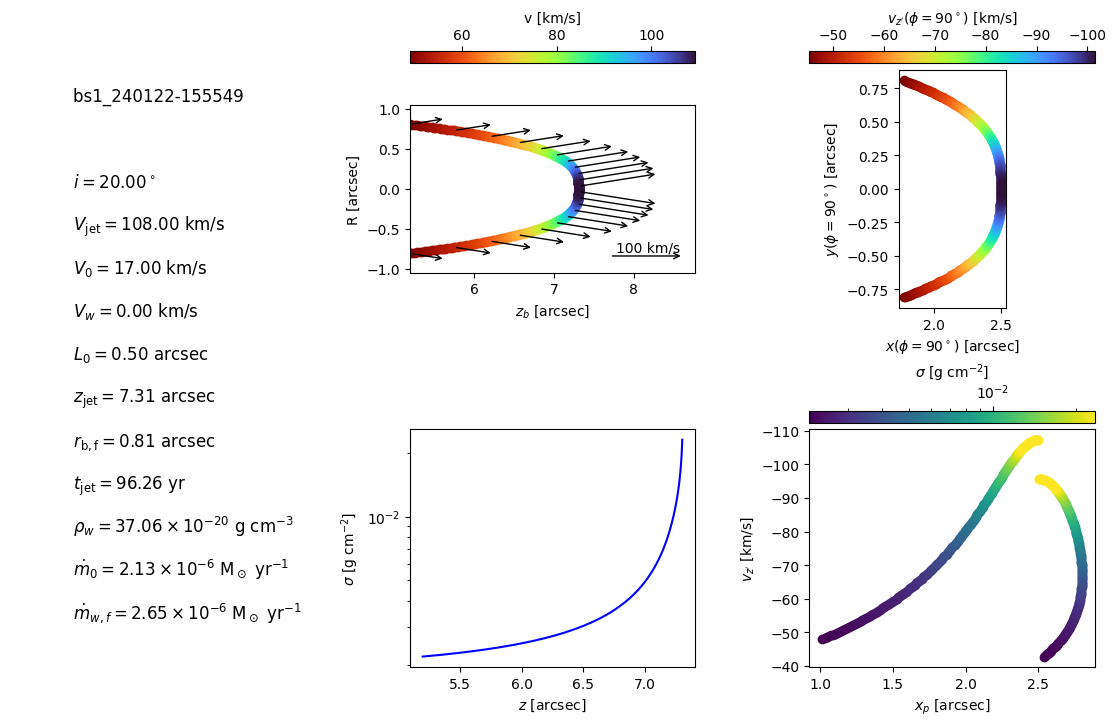

In [7]:
p = bs.Bowshock2DPlots(ps, psobs)

In [8]:
rk = "bs1"

ps = { 
 "modelname": f"{rk}_{now}",
 'rj': 0.00,
 'L0': (0.5 * 300 * u.au).to(u.km).value,   
 'zj': (7.31 * 300 * u.au).to(u.km).value,
 'vj': 108,
 'vw': 0,   
 'v0': 17.,
 'rbf_obs': None,
# 'rbf_obs': (1 * 300 * u.au).to(u.km).value,
 'mass': 0.00031,   
}
bsm = bs.NJ(ps)

psobs = { 
 'i': 20 * np.pi / 180,
 'vsys': 0,
 'distpc': 300,
 "nzs": 500,
}
bsmobs = bs.ObsModel(ps, psobs)

pscube = {
    # "nzs": 200,
    "nphis": 500,   
    "nc": 50,
#    "vt": 1,
    "vch0": 0, # center value
    "vchf": -150, # center value   
    "nxs": 250,
    "nys": 250,   
    "refpix": [-25, 125], 
    "xpmax": 3,    
    "pa_rotate": -40,
    "ybeam": 1 * 3600,
    "xbeam": 0.5 * 3600,
    "pabeam": 30,
    # "mass": 0.0005,
    # 'rbf_obs': bsm.rbf, #(0.95 * 300*u.au).to(u.km).value,
    "Tex": 100,
    "CIC": True,
}

# pars = {**ps, **psobs, **pscube}
# Add some usefull keys to pars
pscube["chanwidth"] = (pscube["vchf"] - pscube["vch0"]) / (pscube["nc"]-1)
pscube["vt"] = pscube["chanwidth"] * 2
pscube["arcsecpix"] = pscube["xpmax"] / float(pscube["nxs"])
pscube["x_FWHM"] = pscube["xbeam"] / pscube["arcsecpix"]
pscube["y_FWHM"] = pscube["ybeam"] / pscube["arcsecpix"]
pscube["beamarea"] = np.pi * pscube["y_FWHM"] * pscube["x_FWHM"] / (4 * np.log(2))
if pscube["refpix"] == None:
    if pscube["nxs"]%2 == 0:
        xref = pscube["nxs"] / 2
    else: 
        xref = (pscube["nxs"]-1) / 2
    if pscube["nys"]%2 == 0:
        yref = pscube["nys"] / 2
    else: 
        yref = (pscube["nys"]-1) / 2       
    pscube["refpix"] = [xref, yref]

In [9]:
p = bs.BowshockCube(ps, psobs, pscube)
p.makecube()
p.rotate()

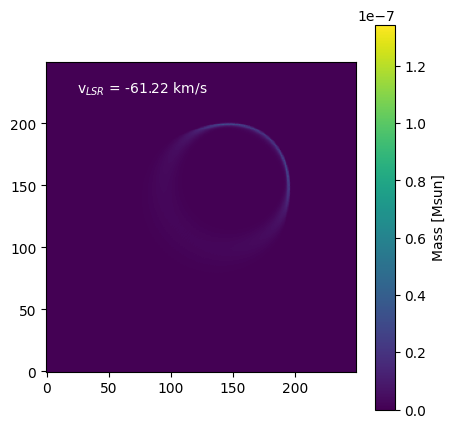

In [10]:
chan = 20 
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    p.cube[chan],
    origin="lower",
    vmax=np.max(p.cube),
    vmin=np.min(p.cube)
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {p.velchans[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

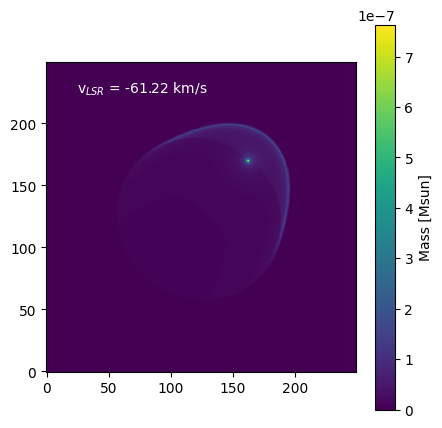

In [11]:
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    np.sum(p.cube, axis=0),
    origin="lower",
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {p.velchans[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

In [15]:
rk = "bs1"

ps = { 
 "modelname": f"{rk}_{now}",
 'rj': 0.00,
 'L0': (2 * 300 * u.au).to(u.km).value,   
 'zj': (7.31 * 300 * u.au).to(u.km).value,
 'vj': 108,
 'vw': 0,   
 'v0': 17.,
 'rbf_obs': None,
# 'rbf_obs': (1 * 300 * u.au).to(u.km).value,
 'mass': 0.00031,   
}
bsm = bs.NJ(ps)

psobs = { 
 'i': 80 * np.pi / 180,
 'vsys': 0,
 'distpc': 300,
 "nzs": 200,
}
bsmobs = bs.ObsModel(ps, psobs)

pscube = {
    # "nzs": 200,
    "nphis": 400,   
    "nc": 8,
#    "vt": 1,
    "vch0": +80, # center value
    "vchf": -80, # center value   
    "nxs": 50,
    "nys": 50,   
    "refpix": [-25, 30], 
    "xpmax": 5,    
    "pa": -160,
    "ybeam": 1 * 3600,
    "xbeam": 0.5 * 3600,
    "pabeam": 30,
    # "mass": 0.0005,
    # 'rbf_obs': bsm.rbf, #(0.95 * 300*u.au).to(u.km).value,
    "Tex": 100,
    "CIC": True,
}

# pars = {**ps, **psobs, **pscube}
# Add some usefull keys to pars
pscube["chanwidth"] = (pscube["vchf"] - pscube["vch0"]) / (pscube["nc"]-1)
pscube["vt"] = pscube["chanwidth"] * 2
pscube["arcsecpix"] = pscube["xpmax"] / float(pscube["nxs"])
pscube["x_FWHM"] = pscube["xbeam"] / pscube["arcsecpix"]
pscube["y_FWHM"] = pscube["ybeam"] / pscube["arcsecpix"]
pscube["beamarea"] = np.pi * pscube["y_FWHM"] * pscube["x_FWHM"] / (4 * np.log(2))
if pscube["refpix"] == None:
    if pscube["nxs"]%2 == 0:
        xref = pscube["nxs"] / 2
    else: 
        xref = (pscube["nxs"]-1) / 2
    if pscube["nys"]%2 == 0:
        yref = pscube["nys"] / 2
    else: 
        yref = (pscube["nys"]-1) / 2       
    pscube["refpix"] = [xref, yref]

In [16]:
p = bs.BowshockCube(ps, psobs, pscube, )
p.makecube()
p.rotate()

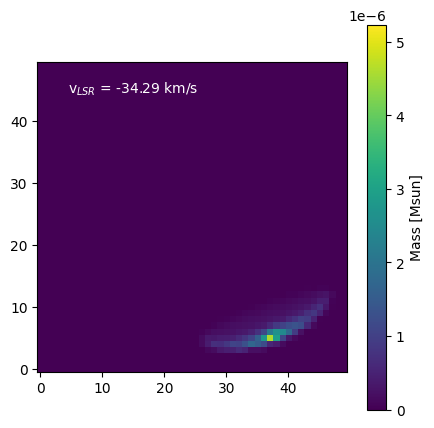

In [23]:
chan = -3 
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    p.cube[chan],
    origin="lower",
    vmax=np.max(p.cube),
    vmin=np.min(p.cube)
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {p.velchans[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

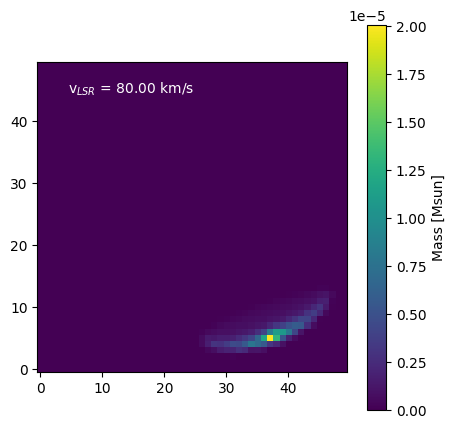

In [547]:
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    np.sum(p.cube, axis=0),
    origin="lower",
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {p.velchans[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

In [489]:
np.sum(p.cube)

0.0003109207477877257

In [293]:
np.max(p.cube)

1.1450271138033733e-06

In [152]:
save2fits = True

mod = bsmobs

nrs = pars["nzs"]
rs = np.linspace(mod.rbf, mod.rj, nrs)
dr = rs[0] - rs[1]
zs = mod.zb_r(rs)
dzs = mod.dz_func(mod.zb_r(rs), dr)

nphis = pars["nphis"]
phis = np.linspace(0, 2*np.pi, nphis+1)[:-1]
dphi = phis[1] - phis[0]

nxs = pars["nxs"] # pixs
nys = pars["nys"] # pixs
# xpmax = pars["xpmax"] #4.386 # arcsec
arcsecpix = pars["arcsecpix"]

vs = np.array([mod.vtot(zb) for zb in zs])
chanwidth = pars["chanwidth"]
velchanss = np.linspace(pars["vch0"], pars["vchf"], pars["nc"])
nchans = len(velchanss) # chans

cube = np.zeros((nchans, nys, nxs))
ci = np.cos(mod.i)
si = np.sin(mod.i)

for iz, z in enumerate(zs):
    t0 = datetime.now()
    if iz != len(zs)-1:
        dmass = mod.dmass_func(z, dzs[iz], dphi)
    else:
        dmass = mod.intmass_analytical(dr/2) / nphis
        
    r = bsm.rb(z)
    print(f"Computing: z = {z:.4f} km, v = {vs[iz]:.4} km/s, r = {r:.4} km")
    print(f"Computing: z = {mod.km2arcsec(z):.4f} acsec, v = {vs[iz]:.4} km/s, r = {mod.km2arcsec(r):.4} arcsec")
        
    for iphi, phi in enumerate(phis):
        xp = r * np.cos(phi) * ci + z * si
        yp = r * np.sin(phi)
        vzp = -mod.vzp(z, phi)
         
        xpixcoord = mod.km2arcsec(xp) / arcsecpix #+ 0.5*((zmax-zmin)*si/arcsecpix) #+ si*nxs #- zmax * si / arcsecpix
        ypixcoord = mod.km2arcsec(yp) / arcsecpix + nys/2
        xpix = int(xpixcoord)
        ypix = int(ypixcoord)
        if (xpix+1<nxs) and (ypix+1<nys) and (xpix>0) and (ypix>0):
            dxpix = xpixcoord - xpix
            dypix = ypixcoord - ypix       
            
            for chan, vchan in enumerate(velchanss):
                diffv = np.abs(vzp-vchan)
                if True:
                    em = dmass * np.exp(-(diffv/vt)**2) / (np.sqrt(np.pi)*vt) * np.abs(chanwidth)
                    if (xpix+1<nxs) and (ypix+1<nys):
                        cube[chan, ypix, xpix] += em * (1-dxpix) * (1-dypix)
                        cube[chan, ypix, xpix+1] += em * dxpix * (1-dypix)
                        cube[chan, ypix+1, xpix] += em * (1-dxpix) * dypix
                        cube[chan, ypix+1, xpix+1] += em * dxpix * dypix           
                else:
                    pass
    tf = datetime.now()
    print(fr"$\Delta t={int((tf-t0).total_seconds()*1000):.1f} ms$")

Computing: z = 231711174111.0721 km, v = 48.64 km/s, r = 3.647e+10 km
Computing: z = 5.1630 acsec, v = 48.64 km/s, r = 0.8127 arcsec
$\Delta t=62.0 ms$
Computing: z = 232674736501.0530 km, v = 48.82 km/s, r = 3.635e+10 km
Computing: z = 5.1844 acsec, v = 48.82 km/s, r = 0.81 arcsec
$\Delta t=56.0 ms$
Computing: z = 233631853681.7679 km, v = 49.01 km/s, r = 3.623e+10 km
Computing: z = 5.2058 acsec, v = 49.01 km/s, r = 0.8073 arcsec
$\Delta t=56.0 ms$
Computing: z = 234582547281.4358 km, v = 49.19 km/s, r = 3.611e+10 km
Computing: z = 5.2270 acsec, v = 49.19 km/s, r = 0.8045 arcsec
$\Delta t=55.0 ms$
Computing: z = 235526838928.2756 km, v = 49.37 km/s, r = 3.599e+10 km
Computing: z = 5.2480 acsec, v = 49.37 km/s, r = 0.8018 arcsec
$\Delta t=57.0 ms$
Computing: z = 236464750250.5063 km, v = 49.56 km/s, r = 3.586e+10 km
Computing: z = 5.2689 acsec, v = 49.56 km/s, r = 0.7991 arcsec
$\Delta t=53.0 ms$
Computing: z = 237396302876.3471 km, v = 49.74 km/s, r = 3.574e+10 km
Computing: z = 5.289

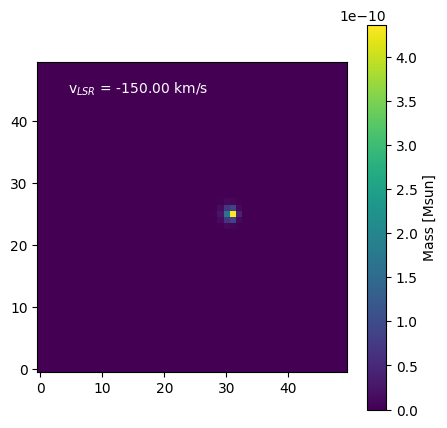

In [153]:
chan = -1 
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    cube[chan],
    origin="lower"
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {velchanss[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

In [154]:
np.sum(cube)

0.00031122328856540455

In [155]:
mod.intmass_analytical(dr/2)

2.4190485388242303e-07

In [17]:
mod.intmass_analytical(mod.rbf)

0.00030999999999999995

In [18]:
pars["mass"]

0.00031

In [63]:
mod.intmass_numerical(0, mod.rbf, return_residual=True)

(1.4495096302936317e-07, 2.2536520597694925e+21)

In [160]:
rk = "bs1"
mod = bsmobs

nrs = pars["nzs"]
# zmax = mod.zj # arcsec
# zmin = mod.zbf # arcsec
# zmin = mod.zb_r(pars["rbf_obs"])
# zsextended = mod.zb_r(np.linspace(pars["rbf_obs"], mod.rj, nrs))
zsextended = mod.zb_r(np.linspace(mod.rbf, mod.rj, nrs))
dzs = (np.diff(zsextended[1:]) + np.diff(zsextended[:-1])) / 2
zs = zsextended[1:-1]
save2fits = True

nphis = pars["nphis"]
phis = np.linspace(0, 2*np.pi, nphis+1)[:-1]
dphi = phis[1] - phis[0]

nxs = pars["nxs"] # pixs
nys = pars["nys"] # pixs
# xpmax = pars["xpmax"] #4.386 # arcsec
arcsecpix = pars["arcsecpix"]

vs = np.array([mod.vtot(zb) for zb in zs])
# velmax = pars["vmin"] # kms
# velmin = pars["vmax"] # kms
chanwidth = pars["chanwidth"]
vt = np.abs(pars["chanwidth"]) * 2
# velchanss = np.arange(velmin, velmax, chanwidth) # in kms
velchanss = np.linspace(pars["vch0"], pars["vchf"], pars["nc"])
nchans = len(velchanss) # chans

cube = np.zeros((nchans, nys, nxs))
ci = np.cos(mod.i)
si = np.sin(mod.i)

for iz, z in enumerate(zs):
    t0 = datetime.now()
    dmass = mod.dmass_func(z, dzs[iz], dphi)
        
    r = bsm.rb(z)
    print(f"Computing: z = {z:.4f} km, v = {vs[iz]:.4} km/s, r = {r:.4} km")
    print(f"Computing: z = {mod.km2arcsec(z):.4f} acsec, v = {vs[iz]:.4} km/s, r = {mod.km2arcsec(r):.4} arcsec")
        
    for iphi, phi in enumerate(phis):
        xp = r * np.cos(phi) * ci + z * si
        yp = r * np.sin(phi)
        vzp = -mod.vzp(z, phi)
         
        xpixcoord = mod.km2arcsec(xp) / arcsecpix #+ 0.5*((zmax-zmin)*si/arcsecpix) #+ si*nxs #- zmax * si / arcsecpix
        ypixcoord = mod.km2arcsec(yp) / arcsecpix + nys/2
        xpix = int(xpixcoord)
        ypix = int(ypixcoord)
        if (xpix+1<nxs) and (ypix+1<nys) and (xpix>0) and (ypix>0):
            dxpix = xpixcoord - xpix
            dypix = ypixcoord - ypix       
            
            for chan, vchan in enumerate(velchanss):
                diffv = np.abs(vzp-vchan)
                if True:
                    em = dmass * np.exp(-(diffv/vt)**2) / (np.sqrt(np.pi)*vt) * np.abs(chanwidth)
                    if (xpix+1<nxs) and (ypix+1<nys):
                        cube[chan, ypix, xpix] += em * (1-dxpix) * (1-dypix)
                        cube[chan, ypix, xpix+1] += em * dxpix * (1-dypix)
                        cube[chan, ypix+1, xpix] += em * (1-dxpix) * dypix
                        cube[chan, ypix+1, xpix+1] += em * dxpix * dypix           
                else:
                    pass
    tf = datetime.now()
    print(fr"$\Delta t={int((tf-t0).total_seconds()*1000):.1f} ms$")

Computing: z = 232674736501.0530 km, v = 48.82 km/s, r = 3.635e+10 km
Computing: z = 5.1844 acsec, v = 48.82 km/s, r = 0.81 arcsec
$\Delta t=70.0 ms$
Computing: z = 233631853681.7679 km, v = 49.01 km/s, r = 3.623e+10 km
Computing: z = 5.2058 acsec, v = 49.01 km/s, r = 0.8073 arcsec
$\Delta t=58.0 ms$
Computing: z = 234582547281.4358 km, v = 49.19 km/s, r = 3.611e+10 km
Computing: z = 5.2270 acsec, v = 49.19 km/s, r = 0.8045 arcsec
$\Delta t=56.0 ms$
Computing: z = 235526838928.2756 km, v = 49.37 km/s, r = 3.599e+10 km
Computing: z = 5.2480 acsec, v = 49.37 km/s, r = 0.8018 arcsec
$\Delta t=46.0 ms$
Computing: z = 236464750250.5063 km, v = 49.56 km/s, r = 3.586e+10 km
Computing: z = 5.2689 acsec, v = 49.56 km/s, r = 0.7991 arcsec
$\Delta t=49.0 ms$
Computing: z = 237396302876.3471 km, v = 49.74 km/s, r = 3.574e+10 km
Computing: z = 5.2897 acsec, v = 49.74 km/s, r = 0.7964 arcsec
$\Delta t=46.0 ms$
Computing: z = 238321518434.0168 km, v = 49.93 km/s, r = 3.562e+10 km
Computing: z = 5.310

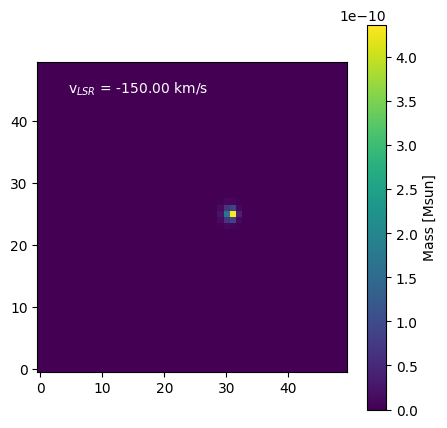

In [161]:
chan = -1 
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    cube[chan],
    origin="lower"
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {velchanss[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

In [162]:
np.sum(cube)

0.0003088038063497441

In [22]:
pars["mass"]

0.00031

In [78]:
chanwidth

-2.1739130434782608

In [14]:
np.diff([3,2])

array([-1])

In [15]:
p.R_arrow_ref_tip

array([-0.84095145])

In [16]:
len(p.Rs_arrows_tip)

11

In [17]:
ps = {
    "nzs": 200,
    "nphis": 500,   
    "nc": 6,
    "vt": 1,
    "vmin": 10,
    "vmax": 110,   
    "nxs": 50,
    "nys": 50,   
    "xpmax": 4,    
    "pa_rotate": -40,
    "ybeam": 1 * 3600,
    "xbeam": 0.5 * 3600,
    "pabeam": 30,
    "mass": 0.0005,
    'rbf_obs': 0.95,
    "Tex": 100,
    "CIC": True,
}

p = ObsNJ(ps)

NameError: name 'ObsNJ' is not defined

In [18]:
p.tj

3037667874.4916663

In [19]:
(bsm[rk].rhow *u.solMass / (300*u.au)**3).to(u.g/u.cm**3) #* (u.arcsec/(u.au/(300*u.pc)))**3

TypeError: 'NJ' object is not subscriptable

In [17]:
pars = {
    "nzs": 200,
    "nphis": 500,   
    "nc": 6,
    "vt": 1,
    "vmin": 10,
    "vmax": 110,   
    "nxs": 50,
    "nys": 50,   
    "xpmax": 4,    
    "pa_rotate": -40,
    "ybeam": 1 * 3600,
    "xbeam": 0.5 * 3600,
    "pabeam": 30,
    "mass": 0.0005,
    'rbf_obs': 0.95,
    "Tex": 100,
    "CIC": True,
}

pars.update(ps)

ut.make_folder(pars["foldername"])
ut.write_log(path=f"{pars['foldername']}/params.txt", mode="w", pars=pars)

# Add some usefull keys to pars
pars["chanwidth"] = np.abs(pars["vmax"] - pars["vmin"]) / pars["nc"]
pars["vt"] = pars["chanwidth"] * 2
pars["arcsecpix"] = pars["xpmax"] / float(pars["nxs"])
pars["x_FWHM"] = pars["xbeam"] / pars["arcsecpix"]
pars["y_FWHM"] = pars["ybeam"] / pars["arcsecpix"]
pars["beamarea"] = np.pi * pars["y_FWHM"] * pars["x_FWHM"] / (4 * np.log(2))
pars["i"] = pars["i"] * np.pi / 180

AttributeError: module 'bowpy.utils' has no attribute 'make_folder'

In [30]:
rk = "bs1"
mod = bsm[rk]

nzs = pars["nzs"]
# zmax = mod.zj # arcsec
# zmin = mod.zbf # arcsec
# zmin = mod.zb_r(pars["rbf_obs"])
zsextended = mod.zb_r(np.linspace(pars["rbf_obs"], mod.rj, nzs))
dzs = (np.diff(zsextended[1:]) + np.diff(zsextended[:-1])) / 2
zs = zsextended[1:-1]
save2fits = True

nphis = pars["nphis"]
phis = np.linspace(0, 2*np.pi, nphis+1)[:-1]
dphi = phis[1] - phis[0]

nxs = pars["nxs"] # pixs
nys = pars["nys"] # pixs
# xpmax = pars["xpmax"] #4.386 # arcsec
arcsecpix = pars["arcsecpix"]

vs = np.array([mod.vtot(zb) for zb in zs])
velmax = -pars["vmin"] # kms
velmin = -pars["vmax"] # kms
chanwidth = pars["chanwidth"]
vt = pars["chanwidth"] * 2
velchanss = np.arange(velmin, velmax, chanwidth) # in kms
nchans = len(velchanss) # chans

cube = np.zeros((nchans, nys, nxs))
ci = np.cos(mod.i)
si = np.sin(mod.i)

for iz, z in enumerate(zs):
    t0 = datetime.now()
    dmass = mod.dmass_func(z, dzs[iz], dphi)
        
    r = bsm[rk].rb(z)
    print(f"Computing: z = {z:.4f} acsec, v = {vs[iz]:.4} km/s, r = {r:.4} arcsec")
        
    for iphi, phi in enumerate(phis):
        xp = r * np.cos(phi) * ci + z * si
        yp = r * np.sin(phi)
        vzp = -mod.vz_obs(z, phi)
         
        xpixcoord = xp / arcsecpix #+ 0.5*((zmax-zmin)*si/arcsecpix) #+ si*nxs #- zmax * si / arcsecpix
        ypixcoord = yp / arcsecpix + nys/2
        xpix = int(xpixcoord)
        ypix = int(ypixcoord)
        if (xpix+1<nxs) and (ypix+1<nys) and (xpix>0) and (ypix>0):
            dxpix = xpixcoord - xpix
            dypix = ypixcoord - ypix       
            
            for chan, vchan in enumerate(velchanss):
                diffv = np.abs(vzp-vchan)
                if True:
                    em = dmass * np.exp(-(diffv/vt)**2) / (np.sqrt(np.pi)*vt) * chanwidth
                    if (xpix+1<nxs) and (ypix+1<nys):
                        cube[chan, ypix, xpix] += em * (1-dxpix) * (1-dypix)
                        cube[chan, ypix, xpix+1] += em * dxpix * (1-dypix)
                        cube[chan, ypix+1, xpix] += em * (1-dxpix) * dypix
                        cube[chan, ypix+1, xpix+1] += em * dxpix * dypix           
                else:
                    pass
    tf = datetime.now()
    print(fr"$\Delta t={int((tf-t0).total_seconds()*1000):.1f} ms$")

Computing: z = -0.8395 acsec, v = 40.68 km/s, r = 0.9452 arcsec
$\Delta t=13.0 ms$
Computing: z = -0.7886 acsec, v = 40.94 km/s, r = 0.9405 arcsec
$\Delta t=9.0 ms$
Computing: z = -0.7382 acsec, v = 41.2 km/s, r = 0.9357 arcsec
$\Delta t=20.0 ms$
Computing: z = -0.6883 acsec, v = 41.46 km/s, r = 0.9309 arcsec
$\Delta t=13.0 ms$
Computing: z = -0.6389 acsec, v = 41.73 km/s, r = 0.9261 arcsec
$\Delta t=11.0 ms$
Computing: z = -0.5900 acsec, v = 41.99 km/s, r = 0.9214 arcsec
$\Delta t=14.0 ms$
Computing: z = -0.5416 acsec, v = 42.26 km/s, r = 0.9166 arcsec
$\Delta t=11.0 ms$
Computing: z = -0.4937 acsec, v = 42.53 km/s, r = 0.9118 arcsec
$\Delta t=12.0 ms$
Computing: z = -0.4464 acsec, v = 42.81 km/s, r = 0.907 arcsec
$\Delta t=10.0 ms$
Computing: z = -0.3995 acsec, v = 43.08 km/s, r = 0.9023 arcsec
$\Delta t=9.0 ms$
Computing: z = -0.3531 acsec, v = 43.36 km/s, r = 0.8975 arcsec
$\Delta t=8.0 ms$
Computing: z = -0.3072 acsec, v = 43.64 km/s, r = 0.8927 arcsec
$\Delta t=8.0 ms$
Computing:

In [31]:
cubes["bs_m"] = cube
velchans["bs_m"] = velchanss + pars["vsys"]

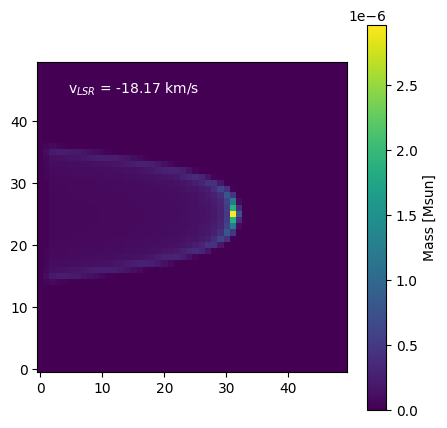

In [35]:
bsk = "bs_m"

chan = 5 
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    cubes[bsk][chan],
    origin="lower"
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {velchans[bsk][chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

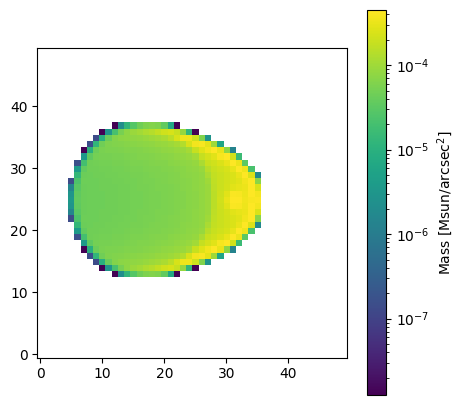

In [26]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

intcube = np.sum(cube, axis=0)/arcsecpix**2
im = ax.imshow(
    intcube,
    origin="lower",
    norm=LogNorm(
        vmin=np.percentile(intcube[intcube!=0],1),
        vmax=np.percentile(intcube[intcube!=0],98)),
#    vmax=0.000001,
)
plt.colorbar(im, label=r"Mass [Msun/arcsec$^2$]" )

/home/guille/py_envs/radio310/lib/python3.10/svs13py/moments.py:21: RuntimeWarning: invalid value encountered in divide
  return sumIixvi(cube, chan_vels, chan_range) / sumint(cube, chan_range)


Text(0, 0.5, 'Dec. Offset [arcsec]')

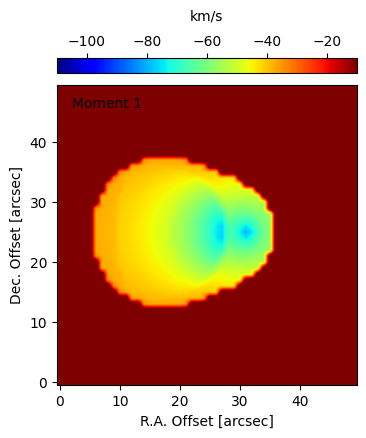

In [27]:
bk = "bs_m"
bg = None
clipping = 10**(-8) 

wspace = 0.0
hspace = 0.05
height_ratios = [0.05, 1]
width_ratios = [1]
figscale = 3

fig = plt.figure(figsize=(figscale*(np.sum(width_ratios)+wspace), 
                          figscale*(np.sum(height_ratios)+hspace)))
gs = GridSpec(2, 1, 
              height_ratios=height_ratios,
              width_ratios=width_ratios)

gs.update(left=0, right=1,
          bottom=0, top=1,
          wspace=wspace, hspace=hspace)

ax = plt.subplot(gs[1, 0])
cbax = plt.subplot(gs[0, 0])
cmap_ref = "jet_r"
if type(cmap_ref) is str:
    cmap = cm.get_cmap(cmap_ref, 256)
else:
    cmap = cmap_ref
velcolors = cmap(np.linspace(0, 1, 256))
if bg == "black":
    bgcolor = np.array([0/256, 0/256, 0/256, 1])
    velcolors[:1, :] = bgcolor
elif bg == "white":
    bgcolor = np.array([256/256, 256/256, 256/256, 1])
    velcolors[:1, :] = bgcolor
else:
    pass

velcmap = ListedColormap(velcolors)
velcenter = velmax + (-velmax+velmin) / 2
chan0 = 0
chanf = np.shape(cubes[bk])[0]
cube_clipped = np.copy(cubes[bk])
cube_clipped[cube_clipped<clipping] = 0
data = np.nan_to_num(
          moments.mom1(
             cube_clipped,
             chan_vels=velchans[bk],
             chan_range=[chan0, chanf])
             )

velcmap = ListedColormap(velcolors[::-1])
velminmom1 = np.min(data)
velmaxmom1 = np.max(data)
velcentermom1 = velmaxmom1+velminmom1
im = ax.imshow(
    data,
#    extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
    origin="lower",
    norm=TwoSlopeNorm(vmin=velmin, vcenter=velcenter, vmax=velmax),
    cmap=velcmap,
    interpolation="bilinear",
)

#pa = pars['beampa'] * np.pi/180. + np.pi/2
## in radians
#a = pars['beammaj'] #/ pars['arcsecpix']
## semi-major axis in pixels
#b = pars['beammin'] #/ pars['arcsecpix']   #semi-minor axis in pixels
#xpos = -2.
#ypos = -2.
#geometry = EllipseGeometry(x0=xpos, y0=ypos,
#                           sma=a*0.5, eps=(1-b/a), pa=pa)
#aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
#                           geometry.sma*(1 - geometry.eps),
#                           geometry.pa)
#   
#aper.plot(ax,
#          color="w",
#          linewidth=2,
#          transform=ax.transData)

ax.text(0.05, 0.925, f"Moment 1", color="k", transform=ax.transAxes)

plt.colorbar(im, cax=cbax, orientation="horizontal",)
cbax.tick_params(axis="x", top=True, bottom=False, labelbottom=False,
                 labeltop=True,)
cbax.set_xlabel(r"km/s", labelpad=10, fontsize=10)
cbax.xaxis.set_label_position("top")

ax.set_xlabel("R.A. Offset [arcsec]")
ax.set_ylabel("Dec. Offset [arcsec]")

# bs.make_folder(foldername=f'{pars["foldername"]}/moments')      
#fig.savefig(f'mom1_{bk}.pdf',
#            bbox_inches="tight")

In [25]:
mpars = {
    "muH2": 2.8, # Mean molecular mass per H molecule
    "XCO": 8.5*10**(-5),
}

mpars["meanmass"] = mpars["muH2"] / (6.023*10**23) * u.g

Tex = pars["Tex"] * u.K

areapix_cm = ((pars["arcsecpix"]*pars["distpc"]*u.au)**2).to(u.cm**2)
cubes["bs_NCO"] = (cubes["bs_m"] * u.solMass * mpars["XCO"] / mpars["meanmass"] / areapix_cm).to(u.cm**(-2)).value * pars["NCOfactor"]
cubes["bs_tau"] = comass.tau_N(
    nu=mf.freq_caract_CO["3-2"],
    J=3, 
    mu=0.112*u.D,
    Tex=Tex,
    Tbg=2.7*u.K,
    dNdv=cubes[f"bs_NCO"]*u.cm**(-2) / (pars["chanwidth"]*u.km/u.s),
).to("")

beamarea_sr = mf.mb_sa_gaussian_f(
    pars["xbeam"]*u.arcsec,
    pars["ybeam"]*u.arcsec
).to(u.sr)

cubes["bs_I"] = (comass.Inu_tau(
    nu=mf.freq_caract_CO["3-2"],
    Tex=Tex,
    Tbg=2.7*u.K,
    tau=cubes["bs_tau"],
)*beamarea_sr).to(u.Jy).value

cubes["bs_Ithin"] = (comass.Inu_tau(
    nu=mf.freq_caract_CO["3-2"],
    Tex=Tex,
    Tbg=2.7*u.K,
    tau=cubes["bs_tau"],
)*beamarea_sr).to(u.Jy).value

In [26]:
kqs = ["I", "tau", "NCO"] # Ihin

cks = list(np.array([
    [f"bs_{kq}s",
     f"bs_{kq}sr",
     f"bs_{kq}src",
     f"bs_{kq}srcr",] for kq in kqs
    ]).flatten())

for ck in cks:
    cubes[ck] = np.zeros_like(cubes["bs_m"])

# xshift = float(pars["xpmax"]/2) + pars["xhead"] - pars["xSVS13"]
# yshift = float(pars["xpmax"]/2) - pars["ySVS13"]
# xshiftpix = int(np.round(xshift / pars["arcsecpix"]))
# yshiftpix = int(np.round(yshift / pars["arcsecpix"]))

for kq in kqs: 
    for chan in range(np.shape(cubes[f"bs_{kq}"])[0]):
        # # noise_matrix:
        # sigma_noise = target_noise * 2 * np.sqrt(np.pi) \
        #         * np.sqrt(pars["x_FWHM"]*pars["y_FWHM"]) / 2.35    
        # noise_matrix = np.random.normal(0, sigma_noise, size=np.shape(cubes["bs_I"][chan]))
        
        # Shift
        cubes[f"bs_{kq}s"][chan] = cubes[f"bs_{kq}"][chan]
        # if (xshift>=0) and (yshift>=0):
        #     cubes[f"bs_{kq}s"][chan] = np.pad(cubes[f"bs_{kq}"][chan][yshiftpix:, xshiftpix:],
        #                          np.array([(0, yshiftpix), (0, xshiftpix)]))
        # elif (xshift<0) and (yshift>=0):
        #     cubes[f"bs_{kq}s"][chan] = np.pad(cubes[f"bs_{kq}"][chan][yshiftpix:, :xshiftpix],
        #                          np.array([(0, yshiftpix), (-xshiftpix, 0)]))              
        # elif (xshift>=0) and (yshift<0):
        #     cubes[f"bs_{kq}s"][chan] = np.pad(cubes[f"bs_{kq}"][chan][:yshiftpix, xshiftpix:],
        #                          np.array([(-yshiftpix,0), (0, xshiftpix)]))                 
        # elif (xshift<0) and (yshift<0):
        #     cubes[f"bs_{kq}s"][chan] = np.pad(cubes[f"bs_{kq}"][chan][:yshiftpix, :xshiftpix],
        #                         np.array([(-yshiftpix,0), (-xshiftpix, 0)]))                        
        
        # Add SVS13 position
        # if add_source:
        #     xSVS13pix = int(np.round(pars["xSVS13"] / pars["arcsecpix"]))
        #     ySVS13pix = int(np.round(pars["ySVS13"] / pars["arcsecpix"]))
        #     cubes["bs_Is"][chan][ySVS13pix, xSVS13pix] = maxval_cube
    
        # Rotate
        cubes[f"bs_{kq}sr"][chan] = rotate(
            cubes[f"bs_{kq}s"][chan],
            angle=pars["pa_rotate"]+90,
            reshape=False,
            order=1)
    
        # Convolve
        cubes[f"bs_{kq}src"][chan], testkernel = bs.gaussconvolve(
            cubes[f"bs_{kq}sr"][chan],
            x_FWHM=pars["x_FWHM"],
            y_FWHM=pars["y_FWHM"],
            pa=pars["pabeam"],
            return_kernel=True)   
        
        # Rotate for PV
        cubes[f"bs_{kq}srcr"][chan] = rotate(
            cubes[f"bs_{kq}src"][chan],
            angle=-(pars["pa_rotate"]+90),
            reshape=False,
            order=1)       
        
        # Add noise. See appendix
        # if "bs_Isrn" in cks:
        #     cubes["bs_Isrn"][chan] = cubes["bs_Isr"][chan] + noise_matrix
        # 
        # # Convolve noisy image
        # if "bs_Isrnc" in cks:
        #     cubes["bs_Isrnc"][chan] = bs.gaussconvolve(cubes["bs_Isrn"][chan],
        #                                 x_FWHM=pars["x_FWHM"],
        #                                 y_FWHM=pars["y_FWHM"],
        #                                 pa=pars["pabeam"])
        # 
        # # Rotate for PV
        # if "bs_Isrncr" in cks:
        #     cubes["bs_Isrncr"][chan] = rotate(cubes["bs_Isrnc"][chan],
        #                                  angle=-(pars["pa_rotate"]-90),
        #                                  reshape=False,
        #                                  order=1)

In [27]:
# Create header 

hdr = bs.create_hdr(
    NAXIS1 = np.shape(cubes['bs_I'])[0],
    NAXIS2 = np.shape(cubes['bs_I'])[1],
    NAXIS3 = np.shape(cubes['bs_I'])[2],
    CRVAL1 = mf.default_params["vla4b_deg"][0],
    CRVAL2 = mf.default_params["vla4b_deg"][1],
    CRPIX1 = pars["xSVS13pix_sr"],
    CRPIX2 = pars["ySVS13pix_sr"],
    CDELT1 = -pars["arcsecpix"] / 3600,
    CDELT2 = pars["arcsecpix"] / 3600,
    # BTYPE = "Column Density",
    # BUNIT = "Norm",
    CTYPE3 = "VRAD",
    CRVAL3 = velchans['bs_m'][0],
    CDELT3 = velchans['bs_m'][1] - velchans['bs_m'][0],
    CUNIT3 = "km/s",
    BMAJ = pars["ybeam"] / 3600,
    BMIN = pars["xbeam"] / 3600,
    BPA = pars["pabeam"]
)

for bk in cks+["bs_m"]:
    hdrs[bk] = hdr
    wcss[bk] = WCS(hdrs[bk]).celestial
    hdu = fits.PrimaryHDU(cubes[bk])
    hdul = fits.HDUList([hdu])
    hdu.header = hdrs[bk]
    bs.make_folder(foldername=f'{pars["foldername"]}/fits')
    hdul.writeto(f'{pars["foldername"]}/fits/{bk}.fits', overwrite=True)          

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 fro

Text(0, 0.5, 'Surface Density [Msun/arcsec$^2$]')

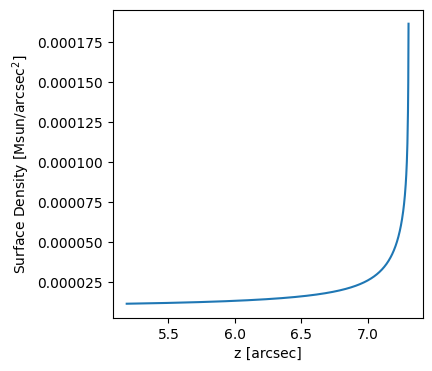

In [9]:
rk = "III"
zs = np.linspace(bsm[rk].zbf, bsm[rk].zj, 1000)[:-1]
surfdenss = np.array([bsm[rk].surfdens(zb) for zb in zs])

fig = plt.figure(figsize=(4,4))
ax = plt.subplot()

ax.plot(zs, surfdenss)
ax.set_xlabel("z [arcsec]")
ax.set_ylabel(r"Surface Density [Msun/arcsec$^2$]")

Text(0, 0.5, 'Surface Density [Msun/arcsec$^2$]')

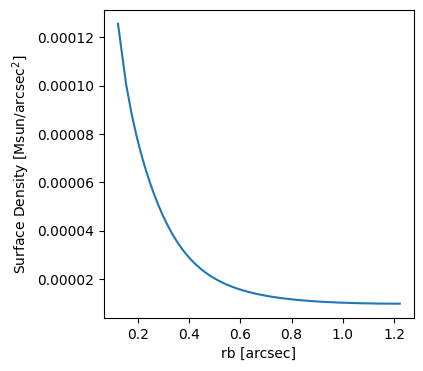

In [10]:
rk = "III"
zs = np.linspace(0, bsm[rk].zj, 1000)[:-1]
rbs = np.array([bsm[rk].rb(zb) for zb in zs])
surfdenss = np.array([bsm[rk].surfdens(zb) for zb in zs])

fig = plt.figure(figsize=(4,4))
ax = plt.subplot()

ax.plot(rbs, surfdenss)
ax.set_xlabel("rb [arcsec]")
ax.set_ylabel(r"Surface Density [Msun/arcsec$^2$]")

### Test: homogeneous bar

Computing: z = 7.2988 acsec, v = 106.4 km/s
$\Delta t=31.0 ms$


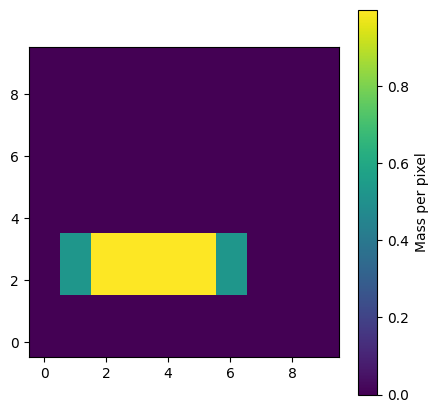

In [13]:
print(f"Computing: z = {z:.4f} acsec, v = {vs[iz]:.4} km/s")
t0 = datetime.now()

nphis = 1000
phis = np.linspace(0, 2*np.pi, nphis)
dphi = phis[1] - phis[0]

nxs = 10 # pixs
nys = 10 # pixs
xpmax = 20 #4.386 # arcsec
arcsecpix = xpmax / nxs

data = np.zeros((nys, nxs))

#arcsecpix = 1
linear_dens = 1
barlength = 10 
barorigin = 2
yp = 5

def dmass(dl):
    return linear_dens * dl

xps = np.linspace(barorigin,barorigin+barlength, 100)
dx = xps[1] - xps[0]
    
for xp in xps:
    xpixcoord = xp / arcsecpix
    ypixcoord = yp / arcsecpix
    xpix = int(xpixcoord)
    ypix = int(ypixcoord)
    if (xpix+1<nxs) and (ypix+1<nys):
        dxpix = xpixcoord - xpix
        dypix = ypixcoord - ypix       
        em = dmass(dx)
        data[ypix, xpix] += em * (1-dxpix) * (1-dypix)
        data[ypix, xpix+1] += em * dxpix * (1-dypix)
        data[ypix+1, xpix] += em * (1-dxpix) * dypix
        data[ypix+1, xpix+1] += em * dxpix * dypix    
            
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()           

im = ax.imshow(data, origin="lower")
plt.colorbar(im, label="Mass per pixel")

tf = datetime.now()
print(fr"$\Delta t={int((tf-t0).total_seconds()*1000):.1f} ms$")


#### Test with CIC (slower, Alex method is quicker and is equivalent)

In [14]:
def shapeCIC(x, X, dx):
    diffx = np.abs(x - X)
    if diffx < dx:
        s = 1 - diffx / dx
    else:
        s = 0
    return s

def alexCIC(xpix, xp, arcsecpix):
    xpixcoord = xp / arcsecpix
    xpixin = int(xpixcoord)
    dxpix = xpixcoord - xpixin
    if (xpixin == xpix):
        s = (1 - dxpix)
    elif (xpixin == xpix+1):
        s = dxpix
    else: 
        s = 0
    return s

Computing
$\Delta t=306.0 ms$


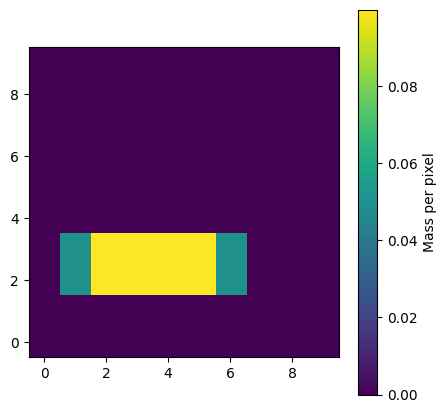

In [475]:
print(f"Computing")
t0 = datetime.now()
nphis = 1000
phis = np.linspace(0, 2*np.pi, nphis)
dphi = phis[1] - phis[0]

nxs = 10 # pixs
nys = 10 # pixs
xpmax = 20 #4.386 # arcsec
arcsecpix = xpmax / nxs

data = np.zeros((nys, nxs))

#arcsecpix = 1
barlength = 10 
barorigin = 2
yp = 5
linear_dens = 1 / barlength

def dmass(dl):
    return linear_dens * dl

xps = np.linspace(barorigin,barorigin+barlength, 1000)
dx = xps[1] - xps[0]

for i, j in np.ndindex(nxs, nys):
    for xp in xps:
        data[j, i] += dmass(dx) * shapeCIC(i*arcsecpix, xp, arcsecpix) * shapeCIC(j*arcsecpix, yp, arcsecpix)
    
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()           

im = ax.imshow(data, origin="lower")
plt.colorbar(im, label="Mass per pixel")

tf = datetime.now()
print(fr"$\Delta t={int((tf-t0).total_seconds()*1000):.1f} ms$")

### Test: homogeneous narrow ring

Computing
$\Delta t=32.0 ms$


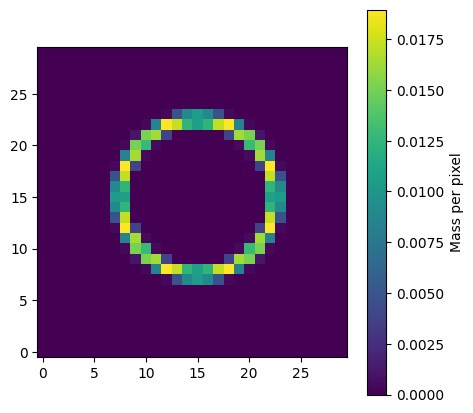

In [471]:
print(f"Computing")
t0 = datetime.now()

nxs = 30 # pixs
nys = 30 # pixs
xpmax = 20 #4.386 # arcsec
arcsecpix = xpmax / nxs

data = np.zeros((nys, nxs))

#arcsecpix = 1
rp = 5
x0p, y0p = 10, 10
angular_dens = 1 / (2*np.pi)

def dmass_ring(dphi):
    return angular_dens * dphi

phis = np.linspace(0, 2*np.pi, 1000)[:-1]
dphi = phis[1] - phis[0]

for phi in phis:
    xp = x0p + rp * np.cos(phi)
    yp = y0p + rp * np.sin(phi)
    xpixcoord = xp / arcsecpix
    ypixcoord = yp / arcsecpix
    xpix = int(xpixcoord)
    ypix = int(ypixcoord)
    if (xpix+1<nxs) and (ypix+1<nys) and (xpix>0) and (ypix>0):
        dxpix = xpixcoord - xpix
        dypix = ypixcoord - ypix       
        em = dmass_ring(dphi)
        data[ypix, xpix] += em * (1-dxpix) * (1-dypix)
        data[ypix, xpix+1] += em * dxpix * (1-dypix)
        data[ypix+1, xpix] += em * (1-dxpix) * dypix
        data[ypix+1, xpix+1] += em * dxpix * dypix    
            
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()           

im = ax.imshow(data, origin="lower")
plt.colorbar(im, label="Mass per pixel")

tf = datetime.now()
print(fr"$\Delta t={int((tf-t0).total_seconds()*1000):.1f} ms$")


In [472]:
np.sum(data)

1.0

### Test: homogeneous ring with non negligible width

Computing
$\Delta t=2156.0 ms$


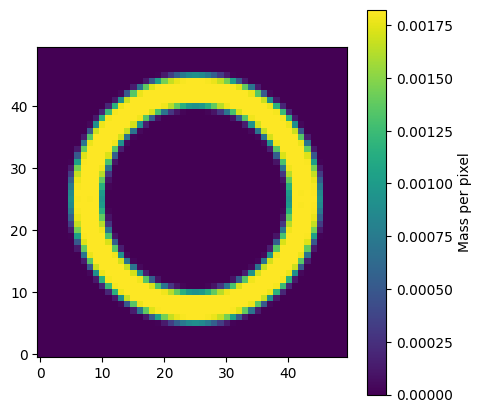

In [483]:
print(f"Computing")
t0 = datetime.now()

nxs = 50 # pixs
nys = 50 # pixs
xpmax = 20 #4.386 # arcsec
arcsecpix = xpmax / nxs

data = np.zeros((nys, nxs))

#arcsecpix = 1
r0, rf = 6, 8 
x0p, y0p = 10, 10

#sigmaring = 0.5
sigmaring = 1 / (np.pi *(rf**2 - r0**2))

#def dmass_annulus(r, dr, dphi):
#    return sigmaring * np.sqrt((r*dphi)**2 + (dr)**2)
def dmass_annulus(r, dr, dphi):
    return sigmaring * dphi * dr * r

phis = np.linspace(0, 2*np.pi, 1000)[:-1]
rs = np.linspace(r0, rf, 500)
dphi = phis[1] - phis[0]
dr = rs[1] - rs[0]

for r, phi in product(rs, phis):
    xp = x0p + r * np.cos(phi)
    yp = y0p + r * np.sin(phi)
    xpixcoord = xp / arcsecpix
    ypixcoord = yp / arcsecpix
    xpix = int(xpixcoord)
    ypix = int(ypixcoord)
    if (xpix+1<nxs) and (ypix+1<nys) and (xpix>0) and (ypix>0):
        dxpix = xpixcoord - xpix
        dypix = ypixcoord - ypix       
        em = dmass_annulus(r, dr, dphi)
        data[ypix, xpix] += em * (1-dxpix) * (1-dypix)
        data[ypix, xpix+1] += em * dxpix * (1-dypix)
        data[ypix+1, xpix] += em * (1-dxpix) * dypix
        data[ypix+1, xpix+1] += em * dxpix * dypix    
            
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()           

im = ax.imshow(data, origin="lower")
plt.colorbar(im, label="Mass per pixel")

tf = datetime.now()
print(fr"$\Delta t={int((tf-t0).total_seconds()*1000):.1f} ms$")


In [484]:
np.sum(data)

1.0020040080160886

# IWS Model

In [8]:
ps = {
    "a":  1.1,
    "z0": 7,
    "zf": 6.8, 
    "vrf": 25,
    "vj": 132,
    "i": 20 * np.pi / 180,
    "rhomax": 1,
    "zinf": 7.025
}

In [9]:
class IWS():
    default_kwargs = {
    }
    def __init__(self, ps, **kwargs):
        for param in ps:
            setattr(self, param.replace("/", "_"), ps[param])
        for kwarg in self.default_kwargs:
            kwarg_attr = kwargs[kwarg] if kwarg in kwargs else self.default_kwargs[kwarg]
            setattr(self, kwarg, kwarg_attr)
    
    def r_z(self, z):
        return np.sqrt(self.a**2 * self.z0 * (self.z0 - z))
    
    def vr(self, z):
        return  self.vrf / (self.z0-self.zf) * (self.z0 - z)
    
    def vz(self, z):
        return self.vj
    
    def vtot(self, z):
        return np.sqrt(self.vz(z)**2 + self.vr(z)**2)
    
    def alpha(self, z):
        """
        This is not the alpha of alex apendix!. Alpha from alex apendix is alpha2.
        Note that when vw=0 this angle is constant
        """
        return np.arctan(self.vr(z) / self.vz(z))
    
    def vz_obs(self, z, phi):
        a = self.alpha(z)
        return self.vtot(z) * (np.cos(a)*np.cos(self.i) - np.sin(a)*np.cos(phi)*np.sin(self.i))
    
    def surfdens(self, z):
        return self.rhomax * np.sqrt((self.zinf - self.z0)/(self.zinf - z))

    def dr_func(self, z, dz):
        """
        Differential of r given a differential of z
        """
        return - 0.5 * self.a**2 * self.z0 / self.r_z(z) * dz

    def dsurf_func(self, z, dz, dphi):
        """
        Differential of surface given a differential in z and phi
        """
        b = (self.a**2*self.z0/2)**2
        r = self.r_z(z)
        return np.sqrt(r**2 + b) * (dz) * dphi

    def intsurf(self, z1, z2):
        b = (self.a**2*self.z0/2)**2
        r1 = self.r_z(z1)
        r2 = self.r_z(z2)
        k1 = 4/3 * np.pi/(self.a**2*self.z0)
        return k1 * (-(r2**2+b)**1.5 + (r1**2+b)**1.5)
    
    def dmass_func(self, z, dz, dphi):
        """
        Differential of mass given a differential in z
        """
        return self.surfdens(z) * self.dsurf_func(z, dz, dphi)


iwsm = {}
iwsm["III"] = IWS(ps)

In [10]:
iwsm["III"].intsurf(6,7)

29.539254537141545

In [11]:
zs = np.linspace(6, 7, 1000)
dz = zs[1] - zs[0]
np.sum([iwsm["III"].dsurf_func(z, dz, 2*np.pi) for z in zs])

29.56873195988419

Text(0, 0.5, 'x [arcsec]')

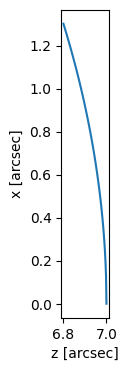

In [12]:
bk = "III"
zs = np.linspace(iwsm[bk].zf, iwsm[bk].z0, 100)
rs = np.array([iwsm[bk].r_z(z) for z in zs])

fig = plt.figure(figsize=(4,4))
ax = plt.subplot()

ax.plot(zs, rs)
ax.set_aspect("equal")
ax.set_xlabel("z [arcsec]")
ax.set_ylabel("x [arcsec]")

Text(0, 0.5, 'v [km/s]')

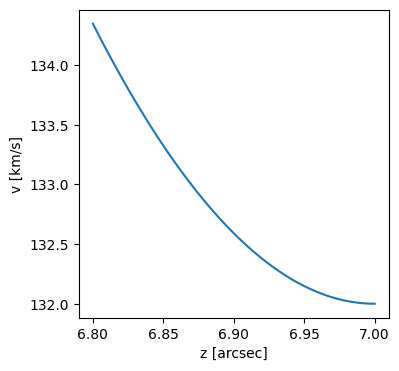

In [13]:
bk = "III"
zs = np.linspace(iwsm[bk].zf, iwsm[bk].z0, 100)
vrs = np.array([iwsm[bk].vtot(z) for z in zs])

fig = plt.figure(figsize=(4,4))
ax = plt.subplot()

ax.plot(zs, vrs)
ax.set_xlabel("z [arcsec]")
ax.set_ylabel("v [km/s]")

Text(0, 0.5, 'surface [arcsec$^2$]')

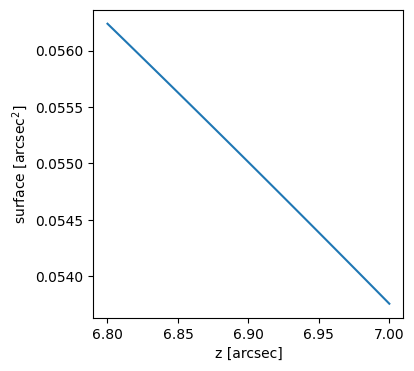

In [14]:
bk = "III"
zs = np.linspace(iwsm[bk].zf, iwsm[bk].z0, 100)
dz = zs[1] - zs[0]
surfs = np.array([iwsm[bk].dsurf_func(z, dz, 2*np.pi) for z in zs])

fig = plt.figure(figsize=(4,4))
ax = plt.subplot()

ax.plot(zs, surfs)
ax.set_xlabel("z [arcsec]")
ax.set_ylabel(r"surface [arcsec$^2$]")

Text(0, 0.5, 'mass [arbitrary units]')

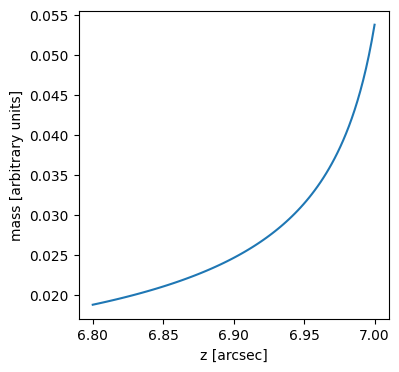

In [15]:
bk = "III"
zs = np.linspace(iwsm[bk].zf, iwsm[bk].z0, 100)
dz = zs[1] - zs[0]
surfs = np.array([iwsm[bk].dmass_func(z, dz, 2*np.pi) for z in zs])

fig = plt.figure(figsize=(4,4))
ax = plt.subplot()

ax.plot(zs, surfs)
ax.set_xlabel("z [arcsec]")
ax.set_ylabel(r"mass [arbitrary units]")

Text(0, 0.5, '$\\rho / \\rho_{max}$ ')

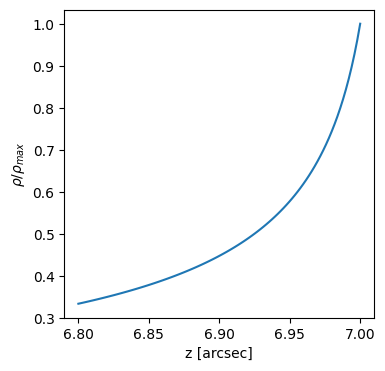

In [16]:
bk = "III"
zs = np.linspace(
    iwsm[bk].zf,
    iwsm[bk].z0,
    100
)
dz = zs[1] - zs[0]
surfdens = np.array([iwsm[bk].surfdens(z) for z in zs])

fig = plt.figure(figsize=(4,4))
ax = plt.subplot()

ax.plot(zs, surfdens)
ax.set_xlabel("z [arcsec]")
ax.set_ylabel(r"$\rho / \rho_{max}$ ")

In [17]:
rk = "III"

nzs = 450
zmax = iwsm[rk].z0 # arcsec
zmin = iwsm[rk].zf # arcsec
zs = np.linspace(zmin, zmax, nzs)
dz = zs[1]-zs[0]

nphis = 500
phis = np.linspace(0, 2*np.pi, nphis+1)[:-1]
dphi = phis[1] - phis[0]

nxs = 100 # pixs
nys = 100 # pixs
xpmax = 5.0 #4.386 # arcsec
arcsecpix = xpmax / nxs

vs = np.array([iwsm[rk].vtot(z) for z in zs])
vt = 4.
velmin = -iwsm[rk].vz_obs(iwsm[rk].zf, np.pi) - vt*2 # kms
velmax = -iwsm[rk].vz_obs(iwsm[rk].zf, 0) + vt*2 # kms
chanwidth = 0.53
vchans = np.arange(velmin, velmax, chanwidth) # in kms
nchans = len(vchans) # chans
tolv = 50 

cube = np.zeros((nchans, nys, nxs))
ci = np.cos(iwsm[rk].i)
si = np.sin(iwsm[rk].i)

for iz, z in enumerate(zs):
    t0 = datetime.now()
    
    # if z<zmax:
    #     dmass = iwsm[rk].dmass_func(z, dz, dphi)
    # else:
    #     dmass = iwsm[rk].dmass_func(z, dz/2, dphi)
    
    dmass = iwsm[rk].dmass_func(z, dz, dphi)
        
    r = iwsm[rk].r_z(z)
    print(f"Computing: z = {z:.4f} acsec, v = {vs[iz]:.4} km/s, r = {r:.4} arcsec")
        
    for iphi, phi in enumerate(phis):
        xp = r * np.cos(phi) * ci + z * si
        yp = r * np.sin(phi)
        vzp = -iwsm[rk].vz_obs(z, phi)
         
        xpixcoord = xp / arcsecpix + si*nxs/2
        ypixcoord = yp / arcsecpix + nys/2
        xpix = int(xpixcoord)
        ypix = int(ypixcoord)
        if (xpix+1<nxs) and (ypix+1<nys) and (xpix>0) and (ypix>0):
            dxpix = xpixcoord - xpix
            dypix = ypixcoord - ypix       
            
            for chan, vchan in enumerate(vchans):
                diffv = np.abs(vzp-vchan)
                if diffv<tolv:
                    em = dmass * np.exp(-(diffv/vt)**2) / (np.sqrt(np.pi)*vt)
                    if (xpix+1<nxs) and (ypix+1<nys):
                        cube[chan, ypix, xpix] += em * (1-dxpix) * (1-dypix)
                        cube[chan, ypix, xpix+1] += em * dxpix * (1-dypix)
                        cube[chan, ypix+1, xpix] += em * (1-dxpix) * dypix
                        cube[chan, ypix+1, xpix+1] += em * dxpix * dypix           
                else:
                    pass
    tf = datetime.now()
    print(fr"$\Delta t={int((tf-t0).total_seconds()*1000):.1f} ms$")


Computing: z = 6.8000 acsec, v = 134.3 km/s, r = 1.302 arcsec
$\Delta t=181.0 ms$
Computing: z = 6.8004 acsec, v = 134.3 km/s, r = 1.3 arcsec
$\Delta t=180.0 ms$
Computing: z = 6.8009 acsec, v = 134.3 km/s, r = 1.299 arcsec
$\Delta t=172.0 ms$
Computing: z = 6.8013 acsec, v = 134.3 km/s, r = 1.297 arcsec
$\Delta t=179.0 ms$
Computing: z = 6.8018 acsec, v = 134.3 km/s, r = 1.296 arcsec
$\Delta t=156.0 ms$
Computing: z = 6.8022 acsec, v = 134.3 km/s, r = 1.294 arcsec
$\Delta t=162.0 ms$
Computing: z = 6.8027 acsec, v = 134.3 km/s, r = 1.293 arcsec
$\Delta t=173.0 ms$
Computing: z = 6.8031 acsec, v = 134.3 km/s, r = 1.291 arcsec
$\Delta t=162.0 ms$
Computing: z = 6.8036 acsec, v = 134.3 km/s, r = 1.29 arcsec
$\Delta t=150.0 ms$
Computing: z = 6.8040 acsec, v = 134.3 km/s, r = 1.288 arcsec
$\Delta t=138.0 ms$
Computing: z = 6.8045 acsec, v = 134.2 km/s, r = 1.287 arcsec
$\Delta t=137.0 ms$
Computing: z = 6.8049 acsec, v = 134.2 km/s, r = 1.285 arcsec
$\Delta t=138.0 ms$
Computing: z = 6.80

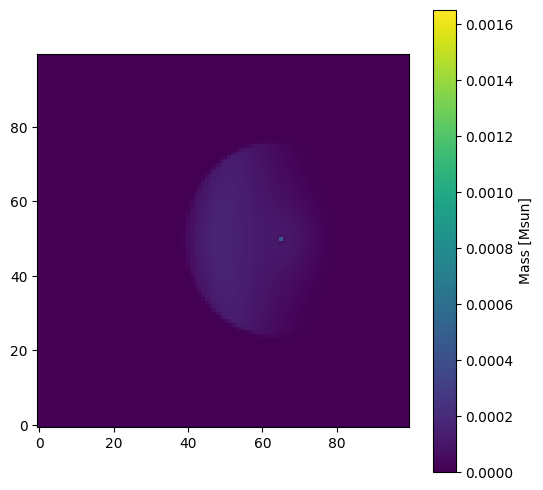

In [19]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot()

im = ax.imshow(
    cube[23],
    vmax=np.max(cube),
    vmin=np.min(cube),
    origin="lower"
)
plt.colorbar(im, label="Mass [Msun]" )

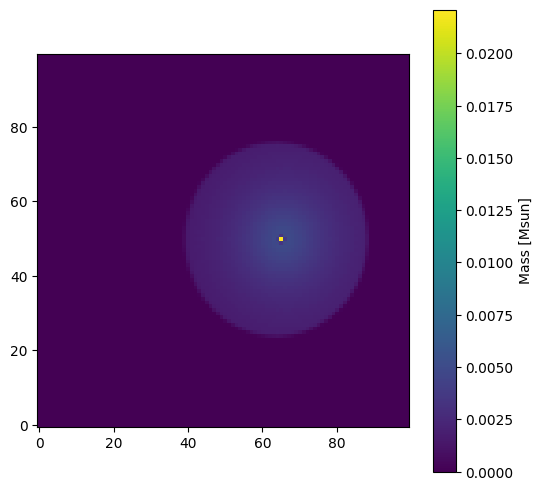

In [20]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot()

im = ax.imshow(
    np.sum(cube, axis=0),
    origin="lower",
)
plt.colorbar(im, label="Mass [Msun]" )

In [431]:
now = datetime.now().strftime("%y%m%d-%H%M%S")
hour = datetime.now().strftime("%y%m%d-%H")
today = datetime.now().strftime("%y%m%d")

ck = "spw17_610kHz"

pars = {
    "foldername": f"prueba_borrar",   
    "outname": 'vchan', 
    "vsys": 0,
    "beampa": hdrs[ck]["BPA"],
    "beammaj": hdrs[ck]["BMAJ"] * 3600,
    "beammin": hdrs[ck]["BMIN"] * 3600,
    "arcsecpix": arcsecpix,
    "pa_rotate": 180-LV_IHV_PV["PA"],
}

pars["x_FWHM"] = pars["beammaj"] / pars["arcsecpix"]
pars["y_FWHM"] = pars["beammin"] / pars["arcsecpix"]

In [432]:
cubes = {}
cubes["iws"] = np.flip(cube, 2)

In [433]:

cks = [
    "iws_r",
    "iws_ri",
    "iws_rc",
    "iws_ric",
    "iws_rcr",
#    "bs_srn",
#    "bs_srnc",
#    "bs_srncr",
]

for ck in cks:
    cubes[ck] = np.zeros_like(cubes["iws"])
for chan in range(np.shape(cubes["iws"])[0]):    
    # Rotate
    if "iws_r" in cks:
        cubes["iws_r"][chan] = rotate(cubes["iws"][chan],
                             angle=pars["pa_rotate"]-90,
                             reshape=False,
                             order=1)
    
    if "iws_rc" in cks:
        cubes["iws_rc"][chan], testkernel = bs.gaussconvolve(cubes["iws_r"][chan],
                                   x_FWHM=pars["x_FWHM"],
                                   y_FWHM=pars["y_FWHM"],
                                   pa=pars["beampa"], return_kernel=True)   
        
    # Rotate for PV
    if "iws_rcr" in cks:
        cubes["iws_rcr"][chan] = rotate(cubes["iws_rc"][chan],
                                     angle=-(pars["pa_rotate"]-90),
                                     reshape=False,
                                     order=1)       

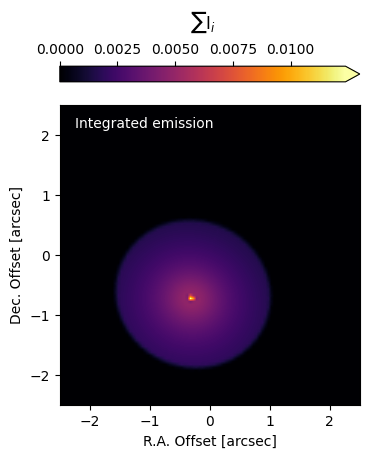

In [434]:
bk = f"iws_r"
wspace = 0.0
hspace = 0.1
height_ratios = [0.05, 1]
width_ratios = [1]
figscale = 3

fig = plt.figure(figsize=(figscale*(np.sum(width_ratios)+wspace), 
                          figscale*(np.sum(height_ratios)+hspace)))
gs = GridSpec(2, 1, 
              height_ratios=height_ratios,
              width_ratios=width_ratios)

gs.update(left=0, right=1,
          bottom=0, top=1,
          wspace=wspace, hspace=hspace)

ax = plt.subplot(gs[1, 0], )
cbax = plt.subplot(gs[0, 0])

#_ = bs.sumint_plot(cubes[bk], ax, cbax, pars, fmaxlim=1, fvcenter=0.5)
im = ax.imshow(
        np.sum(cubes[bk], axis=0),
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        cmap="inferno", 
        interpolation="bilinear"
    )
plt.colorbar(im, cax=cbax, orientation="horizontal", extend="max",)
cbax.tick_params(axis="x", top=True, bottom=False, labelbottom=False,
                 labeltop=True,)
cbax.set_xlabel(r"$\sum\mathrm{I}_i$", labelpad=10, fontsize=12)
cbax.xaxis.set_label_position("top")
 
ax.text(0.05, 0.925, f"Integrated emission", color="w", transform=ax.transAxes)

ax.set_xlabel("R.A. Offset [arcsec]")
ax.set_ylabel("Dec. Offset [arcsec]")

fig.savefig(f'{bk}.pdf',
            bbox_inches="tight")

/home/guille/py_envs/radio310/lib/python3.10/svs13py/moments.py:21: RuntimeWarning: invalid value encountered in divide
  return sumIixvi(cube, chan_vels, chan_range) / sumint(cube, chan_range)


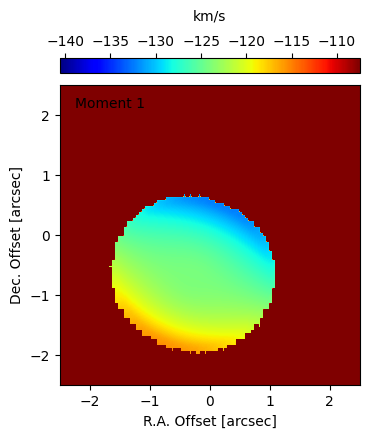

In [435]:
bk = "iws_r"
bg = False
clipping = 0

wspace = 0.0
hspace = 0.05
height_ratios = [0.05, 1]
width_ratios = [1]
figscale = 3

fig = plt.figure(figsize=(figscale*(np.sum(width_ratios)+wspace), 
                          figscale*(np.sum(height_ratios)+hspace)))
gs = GridSpec(2, 1, 
              height_ratios=height_ratios,
              width_ratios=width_ratios)

gs.update(left=0, right=1,
          bottom=0, top=1,
          wspace=wspace, hspace=hspace)

ax = plt.subplot(gs[1, 0])
cbax = plt.subplot(gs[0, 0])
cmap_ref = "jet_r"
if type(cmap_ref) is str:
    cmap = cm.get_cmap(cmap_ref, 256)
else:
    cmap = cmap_ref
velcolors = cmap(np.linspace(0, 1, 256))
if bg == "black":
    bgcolor = np.array([0/256, 0/256, 0/256, 1])
    velcolors[:1, :] = bgcolor
elif bg == "white":
    bgcolor = np.array([256/256, 256/256, 256/256, 1])
    velcolors[:1, :] = bgcolor   
else:
    pass

velcmap = ListedColormap(velcolors)

velcenter = velmax + (-velmax+velmin) / 2
chan0 = 0
chanf = np.shape(cubes[bk])[0]
cube_clipped = np.copy(cubes[bk])
cube_clipped[cube_clipped<clipping] = 0
data = np.nan_to_num(
          moments.mom1(
             cube_clipped,
             chan_vels=vchans,
             chan_range=[chan0, chanf])
             )

velcmap = ListedColormap(velcolors[::-1])
im = ax.imshow(
    data,
    extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
    origin="lower",
    norm=TwoSlopeNorm(vmin=velmin, vcenter=velcenter, vmax=velmax),
    cmap=velcmap,
    interpolation="bilinear",
)

ax.text(0.05, 0.925, f"Moment 1", color="k", transform=ax.transAxes)

plt.colorbar(im, cax=cbax, orientation="horizontal",)
cbax.tick_params(axis="x", top=True, bottom=False, labelbottom=False,
                 labeltop=True,)
cbax.set_xlabel(r"km/s", labelpad=10, fontsize=10)
cbax.xaxis.set_label_position("top")

ax.set_xlabel("R.A. Offset [arcsec]")
ax.set_ylabel("Dec. Offset [arcsec]")

# bs.make_folder(foldername=f'{pars["foldername"]}/moments')      
fig.savefig(f'mom1_{bk}.pdf',
            bbox_inches="tight")

Text(0, 0.5, 'Dec. Offset [arcsec]')

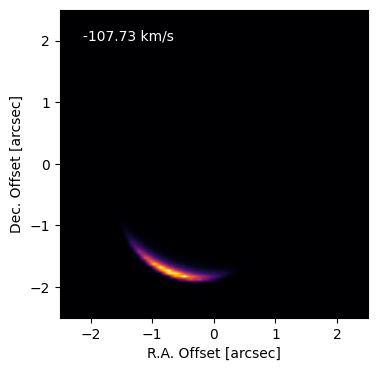

In [436]:
bk = f"iws_r"

chan = 62
vchan = vchans[chan]

fig = plt.figure(figsize=(4,4))
ax = plt.subplot()

ax.imshow(
    cubes[bk][chan],
    origin="lower",
    extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
    interpolation="bilinear",
    cmap="inferno",
)

ax.text(0.075, 0.9, f"{vchan:.2f} km/s", color="w", transform=ax.transAxes)

ax.set_xlabel("R.A. Offset [arcsec]")
ax.set_ylabel("Dec. Offset [arcsec]")


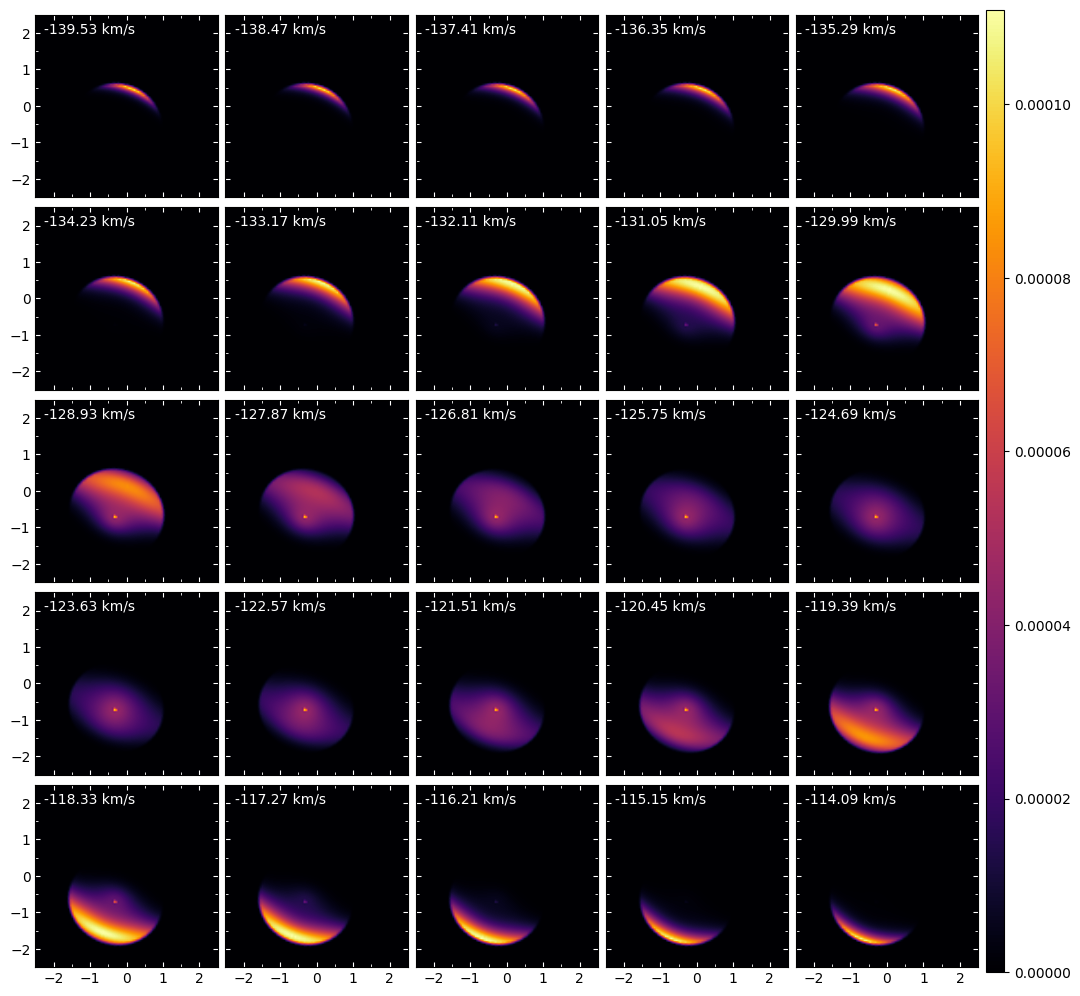

In [437]:
bk = "iws_r"
#kopstr = re.findall("o\d+", bk)
#if kopstr != []:
#    kop = float(kopstr[0].lstrip("o"))
#else:
#    kop = 0

ncol = 5
nrow = 5
wspace = 0.05
hspace = 0.0

size_factor = 2.5
figsize = (ncol*size_factor, nrow*size_factor)
fig = plt.figure(figsize=figsize)
gs = GridSpec(nrow, ncol+1, 
              height_ratios=[1]*nrow,
              width_ratios=[1]*ncol+[0.1])

gs.update(wspace=wspace, hspace=hspace)

axs = {}
for n, (i,j) in enumerate(product(np.arange(nrow), np.arange(ncol))):
    axs[n] = plt.subplot(gs[i,j])
ax_cbar = plt.subplot(gs[:, ncol])

nchanscube = nrow*ncol
chans_plot = nchans
selint = int(chans_plot/nchanscube)
initchan = selint
alldata = cube[initchan::selint]
vmax = None
fvcenter = 0.5
if vmax is None:
    uplim = np.max(alldata)
    norm = TwoSlopeNorm(vcenter=uplim*fvcenter, vmax=uplim, vmin=0)
else:
    vmin = vmin if vmin is not None else 0
    vcenter = vcenter if vcenter is not None else (vmax - vmin) / 2.
    norm = TwoSlopeNorm(vmax=vmax, vcenter=vcenter, vmin=vmin)
    
iter_grid = [
    i for i in product(
        [i for i in range(nrow)],
        [j for j in range(ncol)]
    )
]
 
for chan, (i, j) in enumerate(iter_grid):
    data = cubes[bk][initchan::selint][chan]
    im = axs[chan].imshow(
        data,
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        interpolation="bilinear",
        cmap="inferno",
    )   
    axs[chan].set_aspect("equal")
   
    axs[chan].text(0.05, 0.9,
            s=f"{vchans[initchan::selint][chan]:.2f} km/s",
            color="w",
            transform=axs[chan].transAxes,
            fontsize=10)
    axs[chan].tick_params(
        which="both",
        top=True,
        right=True,
        direction="in",
        color="w",
    )
    axs[chan].xaxis.set_major_locator(ticker.MultipleLocator(1))    
    axs[chan].xaxis.set_minor_locator(ticker.MultipleLocator(0.5))    
    axs[chan].yaxis.set_major_locator(ticker.MultipleLocator(1))    
    axs[chan].yaxis.set_minor_locator(ticker.MultipleLocator(0.5))       
    if (j > 0) and (i < nrow-1):
        axs[chan].set_xticklabels([])
        axs[chan].set_yticklabels([])
    if (i == (nrow-1)) and (j > 0):
        axs[chan].set_yticklabels([])
    if (i < (nrow-1)) and (j == 0):
        axs[chan].set_xticklabels([])
    
plt.colorbar(im, cax=ax_cbar)

fig.savefig(f'channels_{bk}.pdf',
            bbox_inches="tight")

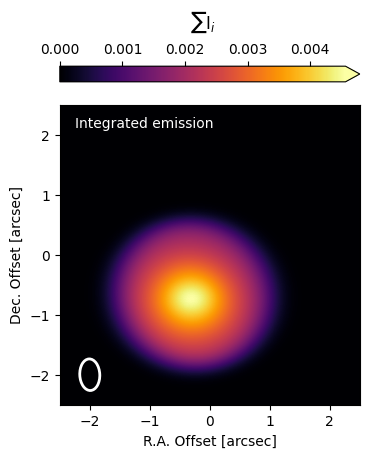

In [438]:
bk = f"iws_rc"
wspace = 0.0
hspace = 0.1
height_ratios = [0.05, 1]
width_ratios = [1]
figscale = 3

fig = plt.figure(figsize=(figscale*(np.sum(width_ratios)+wspace), 
                          figscale*(np.sum(height_ratios)+hspace)))
gs = GridSpec(2, 1, 
              height_ratios=height_ratios,
              width_ratios=width_ratios)

gs.update(left=0, right=1,
          bottom=0, top=1,
          wspace=wspace, hspace=hspace)

ax = plt.subplot(gs[1, 0], )
cbax = plt.subplot(gs[0, 0])

#_ = bs.sumint_plot(cubes[bk], ax, cbax, pars, fmaxlim=1, fvcenter=0.5)
im = ax.imshow(
        np.sum(cubes[bk], axis=0),
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        cmap="inferno", 
        interpolation="bilinear"
    )
 
pa = pars['beampa'] * np.pi/180. + np.pi/2
# in radians
a = pars['beammaj'] #/ pars['arcsecpix']
# semi-major axis in pixels
b = pars['beammin'] #/ pars['arcsecpix']   #semi-minor axis in pixels
xpos = -2.
ypos = -2.
geometry = EllipseGeometry(x0=xpos, y0=ypos,
                           sma=a*0.5, eps=(1-b/a), pa=pa)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
   
aper.plot(ax,
          color="w",
          linewidth=2,
          transform=ax.transData)   
   
plt.colorbar(im, cax=cbax, orientation="horizontal", extend="max",)
cbax.tick_params(axis="x", top=True, bottom=False, labelbottom=False,
                 labeltop=True,)
cbax.set_xlabel(r"$\sum\mathrm{I}_i$", labelpad=10, fontsize=12)
cbax.xaxis.set_label_position("top")
 
ax.text(0.05, 0.925, f"Integrated emission", color="w", transform=ax.transAxes)

ax.set_xlabel("R.A. Offset [arcsec]")
ax.set_ylabel("Dec. Offset [arcsec]")

fig.savefig(f'{bk}.pdf',
            bbox_inches="tight")

/home/guille/py_envs/radio310/lib/python3.10/svs13py/moments.py:21: RuntimeWarning: invalid value encountered in divide
  return sumIixvi(cube, chan_vels, chan_range) / sumint(cube, chan_range)


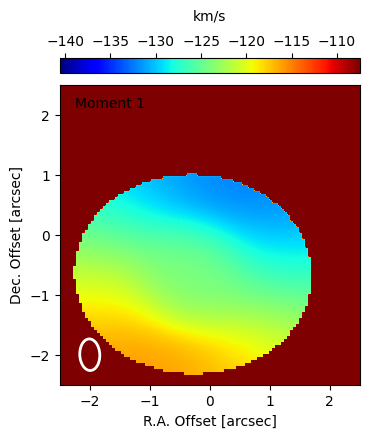

In [439]:
bk = "iws_rc"
bg = None
clipping = 10**(-7) 

wspace = 0.0
hspace = 0.05
height_ratios = [0.05, 1]
width_ratios = [1]
figscale = 3

fig = plt.figure(figsize=(figscale*(np.sum(width_ratios)+wspace), 
                          figscale*(np.sum(height_ratios)+hspace)))
gs = GridSpec(2, 1, 
              height_ratios=height_ratios,
              width_ratios=width_ratios)

gs.update(left=0, right=1,
          bottom=0, top=1,
          wspace=wspace, hspace=hspace)

ax = plt.subplot(gs[1, 0])
cbax = plt.subplot(gs[0, 0])
cmap_ref = "jet_r"
if type(cmap_ref) is str:
    cmap = cm.get_cmap(cmap_ref, 256)
else:
    cmap = cmap_ref
velcolors = cmap(np.linspace(0, 1, 256))
if bg == "black":
    bgcolor = np.array([0/256, 0/256, 0/256, 1])
    velcolors[:1, :] = bgcolor
elif bg == "white":
    bgcolor = np.array([256/256, 256/256, 256/256, 1])
    velcolors[:1, :] = bgcolor
else:
    pass

velcmap = ListedColormap(velcolors)
velcenter = velmax + (-velmax+velmin) / 2
chan0 = 0
chanf = np.shape(cubes[bk])[0]
cube_clipped = np.copy(cubes[bk])
cube_clipped[cube_clipped<clipping] = 0
data = np.nan_to_num(
          moments.mom1(
             cube_clipped,
             chan_vels=vchans,
             chan_range=[chan0, chanf])
             )

velcmap = ListedColormap(velcolors[::-1])
velminmom1 = np.min(data)
velmaxmom1 = np.max(data)
velcentermom1 = velmaxmom1+velminmom1
im = ax.imshow(
    data,
    extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
    origin="lower",
    norm=TwoSlopeNorm(vmin=velmin, vcenter=velcenter, vmax=velmax),
    cmap=velcmap,
    interpolation="bilinear",
)

pa = pars['beampa'] * np.pi/180. + np.pi/2
# in radians
a = pars['beammaj'] #/ pars['arcsecpix']
# semi-major axis in pixels
b = pars['beammin'] #/ pars['arcsecpix']   #semi-minor axis in pixels
xpos = -2.
ypos = -2.
geometry = EllipseGeometry(x0=xpos, y0=ypos,
                           sma=a*0.5, eps=(1-b/a), pa=pa)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
   
aper.plot(ax,
          color="w",
          linewidth=2,
          transform=ax.transData)

ax.text(0.05, 0.925, f"Moment 1", color="k", transform=ax.transAxes)

plt.colorbar(im, cax=cbax, orientation="horizontal",)
cbax.tick_params(axis="x", top=True, bottom=False, labelbottom=False,
                 labeltop=True,)
cbax.set_xlabel(r"km/s", labelpad=10, fontsize=10)
cbax.xaxis.set_label_position("top")

ax.set_xlabel("R.A. Offset [arcsec]")
ax.set_ylabel("Dec. Offset [arcsec]")

# bs.make_folder(foldername=f'{pars["foldername"]}/moments')      
fig.savefig(f'mom1_{bk}.pdf',
            bbox_inches="tight")

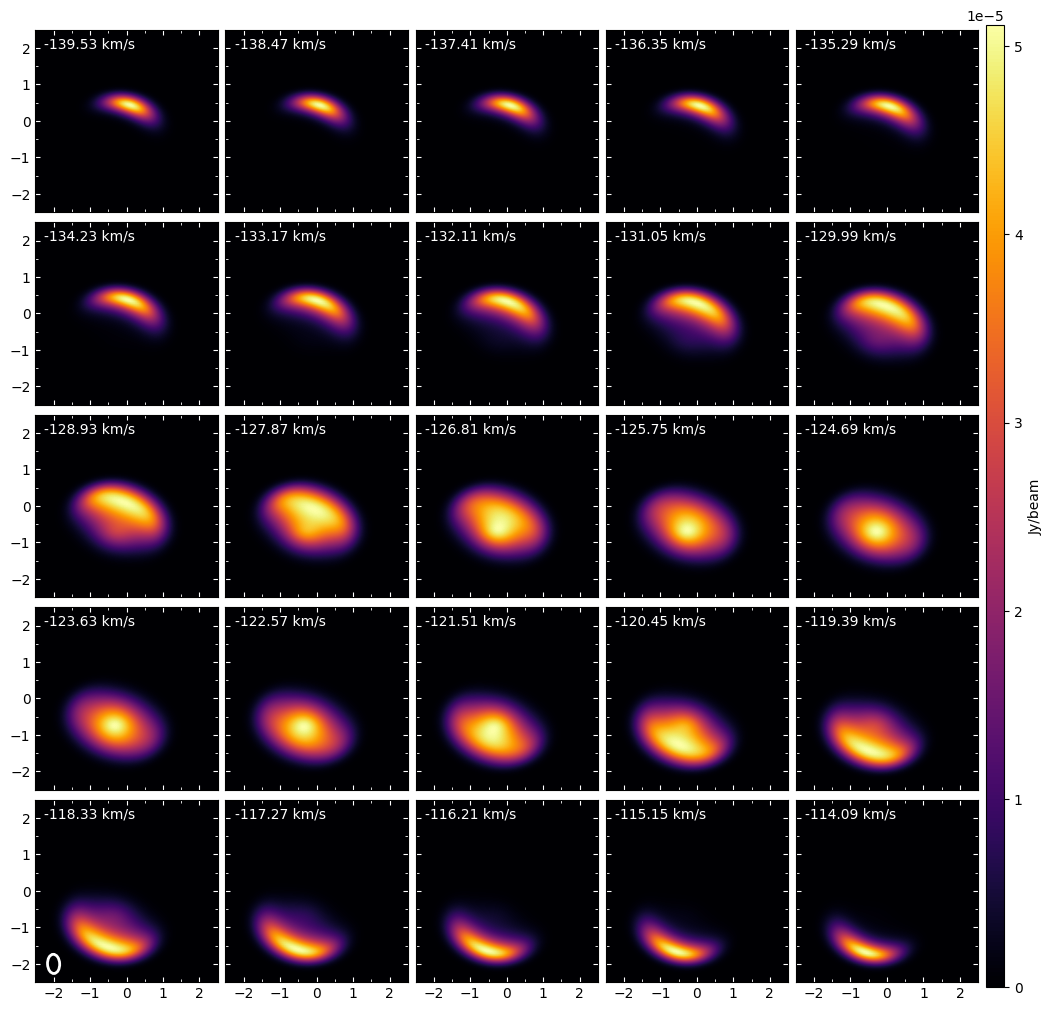

In [511]:
bk = "iws_rc"
#kopstr = re.findall("o\d+", bk)
#if kopstr != []:
#    kop = float(kopstr[0].lstrip("o"))
#else:
#    kop = 0

ncol = 5
nrow = 5
wspace = 0.05
hspace = 0.0

size_factor = 2.5
figsize = (ncol*size_factor, nrow*size_factor)
fig = plt.figure(figsize=figsize)
gs = GridSpec(nrow, ncol+1, 
              height_ratios=[1]*nrow,
              width_ratios=[1]*ncol+[0.1])

gs.update(wspace=wspace, hspace=hspace)

axs = {}
for n, (i,j) in enumerate(product(np.arange(nrow), np.arange(ncol))):
    axs[n] = plt.subplot(gs[i,j])
ax_cbar = plt.subplot(gs[:, ncol])

nchanscube = nrow*ncol
chans_plot = nchans
selint = int(chans_plot/nchanscube)
initchan = selint 
alldata = cube[initchan::selint]
vmax = None
fvcenter = 0.5
if vmax is None:
    uplim = np.max(alldata)
    norm = TwoSlopeNorm(vcenter=uplim*fvcenter, vmax=uplim, vmin=0)
else:
    vmin = vmin if vmin is not None else 0
    vcenter = vcenter if vcenter is not None else (vmax - vmin) / 2.
    norm = TwoSlopeNorm(vmax=vmax, vcenter=vcenter, vmin=vmin)
    
iter_grid = [
    i for i in product(
        [i for i in range(nrow)],
        [j for j in range(ncol)]
    )
]
for chan, (i, j) in enumerate(iter_grid):
    data = cubes[bk][initchan::selint][chan]
    im = axs[chan].imshow(
        data,
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        interpolation="bilinear",
        cmap="inferno",
    )   
    axs[chan].set_aspect("equal")
   
    axs[chan].text(0.05, 0.9,
            s=f"{vchans[initchan::selint][chan]:.2f} km/s",
            color="w",
            transform=axs[chan].transAxes,
            fontsize=10)
    axs[chan].tick_params(
        which="both",
        top=True,
        right=True,
        direction="in",
        color="w",
    )
    axs[chan].xaxis.set_major_locator(ticker.MultipleLocator(1.))    
    axs[chan].xaxis.set_minor_locator(ticker.MultipleLocator(0.5))    
    axs[chan].yaxis.set_major_locator(ticker.MultipleLocator(1.))    
    axs[chan].yaxis.set_minor_locator(ticker.MultipleLocator(0.5))       
    if (j > 0) and (i < nrow-1):
        axs[chan].set_xticklabels([])
        axs[chan].set_yticklabels([])
    if (i == (nrow-1)) and (j > 0):
        axs[chan].set_yticklabels([])
    if (i < (nrow-1)) and (j == 0):
        axs[chan].set_xticklabels([])
    
pa = pars['beampa'] * np.pi/180. + np.pi/2
# in radians
a = pars['beammaj'] #/ pars['arcsecpix']
# semi-major axis in pixels
b = pars['beammin'] #/ pars['arcsecpix']   #semi-minor axis in pixels
xpos = -2.
ypos = -2.
geometry = EllipseGeometry(x0=xpos, y0=ypos,
                           sma=a*0.5, eps=(1-b/a), pa=pa)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
   
aper.plot(axs[nrow*(ncol-1)],
          color="w",
          linewidth=2,
          transform=axs[nrow*(ncol-1)].transData)
    
plt.colorbar(im, cax=ax_cbar)
ax_cbar.set_ylabel("Jy/beam")

fig.savefig(f'channels_{bk}_IWSmodel.pdf',
            bbox_inches="tight")

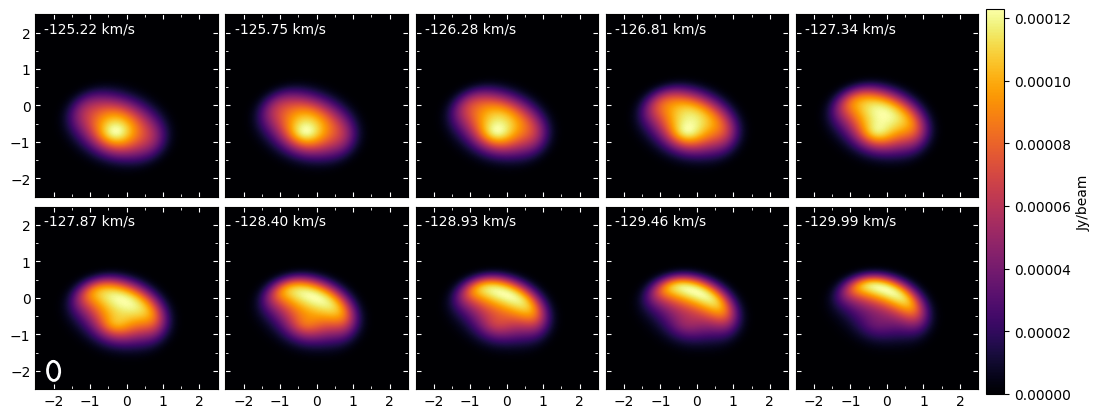

In [512]:
bk = "iws_rc"
#kopstr = re.findall("o\d+", bk)
#if kopstr != []:
#    kop = float(kopstr[0].lstrip("o"))
#else:
#    kop = 0

ncol = 5
nrow = 2
wspace = 0.05
hspace = 0.0

size_factor = 2.5
figsize = (ncol*size_factor, nrow*size_factor)
fig = plt.figure(figsize=figsize)
gs = GridSpec(nrow, ncol+1, 
              height_ratios=[1]*nrow,
              width_ratios=[1]*ncol+[0.1])

gs.update(wspace=wspace, hspace=hspace)

axs = {}
for n, (i,j) in enumerate(product(np.arange(nrow), np.arange(ncol))):
    axs[n] = plt.subplot(gs[i,j])
ax_cbar = plt.subplot(gs[:, ncol])

nchanscube = nrow*ncol
chans_plot = nchans
selint = np.array([51, 50, 49, 48, 47, 46, 45, 44, 43, 42]) - 22
initchan = selint 
alldata = cube[selint]
vmax = None
fvcenter = 0.5
if vmax is None:
    uplim = np.max(alldata)
    norm = TwoSlopeNorm(vcenter=uplim*fvcenter, vmax=uplim, vmin=0)
else:
    vmin = vmin if vmin is not None else 0
    vcenter = vcenter if vcenter is not None else (vmax - vmin) / 2.
    norm = TwoSlopeNorm(vmax=vmax, vcenter=vcenter, vmin=vmin)
    
iter_grid = [
    i for i in product(
        [i for i in range(nrow)],
        [j for j in range(ncol)]
    )
]
for chan, (i, j) in enumerate(iter_grid):
    data = cubes[bk][selint[chan]]
    im = axs[chan].imshow(
        data,
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        interpolation="bilinear",
        cmap="inferno",
    )   
    axs[chan].set_aspect("equal")
   
    axs[chan].text(0.05, 0.9,
            s=f"{vchans[selint[chan]]:.2f} km/s",
            color="w",
            transform=axs[chan].transAxes,
            fontsize=10)
    axs[chan].tick_params(
        which="both",
        top=True,
        right=True,
        direction="in",
        color="w",
    )
    axs[chan].xaxis.set_major_locator(ticker.MultipleLocator(1.))    
    axs[chan].xaxis.set_minor_locator(ticker.MultipleLocator(0.5))    
    axs[chan].yaxis.set_major_locator(ticker.MultipleLocator(1.))    
    axs[chan].yaxis.set_minor_locator(ticker.MultipleLocator(0.5))       
    if (j > 0) and (i < nrow-1):
        axs[chan].set_xticklabels([])
        axs[chan].set_yticklabels([])
    if (i == (nrow-1)) and (j > 0):
        axs[chan].set_yticklabels([])
    if (i < (nrow-1)) and (j == 0):
        axs[chan].set_xticklabels([])
    
pa = pars['beampa'] * np.pi/180. + np.pi/2
# in radians
a = pars['beammaj'] #/ pars['arcsecpix']
# semi-major axis in pixels
b = pars['beammin'] #/ pars['arcsecpix']   #semi-minor axis in pixels
xpos = -2.
ypos = -2.
geometry = EllipseGeometry(x0=xpos, y0=ypos,
                           sma=a*0.5, eps=(1-b/a), pa=pa)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
   
aper.plot(axs[5],
          color="w",
          linewidth=2,
          transform=axs[5].transData)
    
plt.colorbar(im, cax=ax_cbar)
ax_cbar.set_ylabel("Jy/beam")

fig.savefig(f'channels_{bk}_IWSselected.pdf',
            bbox_inches="tight")

In [463]:
channels2plot = [
    211, 
    245,
    253,
    262,
    276,
    297, 
    310,
    # 336,
    341,
    355,
    366,
    371,
    381]

In [464]:
vels_to_plot = np.append(mf.vel_from_header(hdrs["spw2-9_610kHz_2"])[channels2plot],
                         np.array([
                             -100.25,
                             #-104.48,
                             -108.18,
                             -112.95,
                             -116.65
                         ]))
chans2plot_spw17 = [np.argmin(np.abs(vel-mf.vel_from_header(hdrs["spw17_610kHz"])))
                    for vel in vels_to_plot]
print(chans2plot_spw17)

[263, 297, 305, 314, 328, 349, 362, 393, 407, 418, 423, 433, 446, 461, 470, 477]


/home/guille/py_envs/radio310/lib/python3.10/svs13py/SVS13py.py:1438: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(cbar_ticklabels)


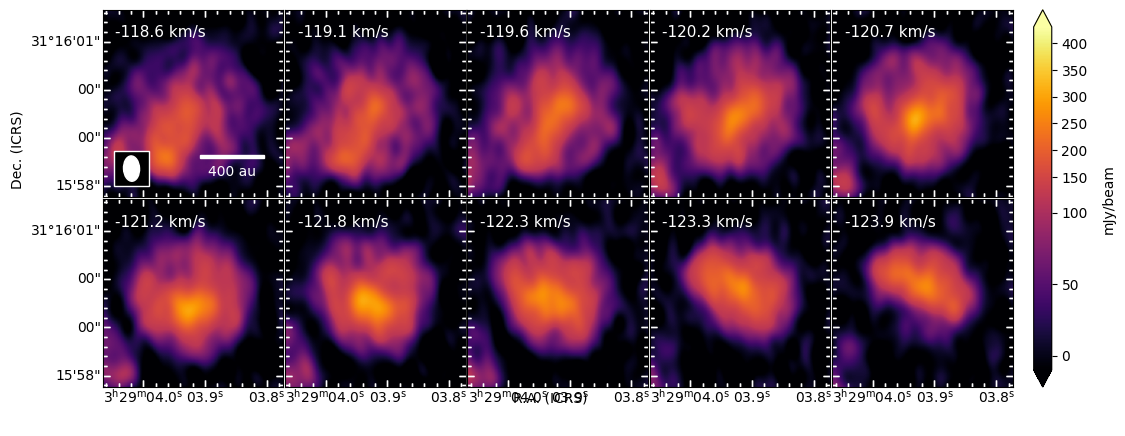

In [513]:
obsck = "spw17_610kHz"
ellip_dic = {}
linewidth = 0.3

#vmax=0.064 vmin=0.0036 vcenter=0.0172
nrow = 2
ncol = 5

# box_wide = [[556-200,786-230],[855,1164]] #box for main bb
# box_bigpic = [[400,500],[900,1200]]
# 
# boxsky_bigpic_lb = pixel_to_skycoord(box_bigpic[0][0], box_bigpic[1][0], wcs=wcss["spw17"])
# boxsky_bigpic_rb = pixel_to_skycoord(box_bigpic[0][1], box_bigpic[1][0], wcs=wcss["spw17"])
# boxsky_bigpic_lu = pixel_to_skycoord(box_bigpic[0][0], box_bigpic[1][1], wcs=wcss["spw17"])
# boxsky_bigpic_ru = pixel_to_skycoord(box_bigpic[0][1], box_bigpic[1][1], wcs=wcss["spw17"])
# 
# box_bigpic_new = [
#     [int(skycoord_to_pixel(boxsky_bigpic_lu, wcs=wcss[obsck])[0]),
#      int(skycoord_to_pixel(boxsky_bigpic_rb, wcs=wcss[obsck])[0])],
#     [int(skycoord_to_pixel(boxsky_bigpic_lb, wcs=wcss[obsck])[1]),
#      int(skycoord_to_pixel(boxsky_bigpic_ru, wcs=wcss[obsck])[1])],   
# ]
box_bigpic_new = [[185, 240], [310, 370]]
chans2plot_spw17 =  [463, 464, 465, 466,467, 468, 469, 470, 472, 473,]


vrel = True
ims = SVS13py.mosaic_slices(cubes[obsck], 
              nrow=nrow, 
              ncol=ncol,
              magical_factor=1.4,
              figscale=1.75,
              chan_0=None, 
              chan_f=None,
              vrel=vrel,
              wcs=wcss[obsck], 
              box=box_bigpic_new, 
              header=hdrs[obsck], 
              add_beam=True, 
              beam_linewidth=1,
              beam_nax=0,
              beam_fill=True,
              add_beam_rectangle=True,
              xpos_beam=20,
              ypos_beam=20,
              beam_factor_rectangle=1.35,
              beam_fill_rectangle=True,
              beam_color_rectangle='k',
              beam_edgecolor_rectangle='w',                       
              colorbar_units='mJy/beam',
              cbar_label_pad=10,
              channels2plot=chans2plot_spw17,
              operation=None, 
              # vmax=0.041,
              # vcenter=0.015,
              # vmin=0.00357,
              vsys=mf.default_params["vla4b_vsys"], 
              vmax=0.43,
              vcenter=0.11,
              vmin=-0.01,                     
              norm='divnorm',
              cmap='inferno',
              x_box=mf.default_params["x_box"]+0.02,
              y_box=mf.default_params["y_box"]-0.03,
              box_fontsize=11,                   
              font_size=10,
              markerstar_color='w', 
              markerstar_width=1.0, 
              markerstar_size=7,
              add_scalebar=True, 
              scalebar_nax=0, 
              scalebar_fontsize=10, 
              scalebar_width=2, 
              scalebar_distance=400, 
              scalebar_units='au', 
              scalebar_pad=1.25, 
              figtext_y_hor=0.08,
              figtext_y_vert=0.2,
              figtext_x_hor=0.2,
              figtext_x_vert=0.1,
              output_format='jpg',
              dpi=250,
#              output_format='pdf',
              # output_name='/NAplots/channels_lowres_nofits',
              # rotate_ticktext_yaxis=90,
              rotate_ticktext_xaxis=0,
              display_x_minor_ticks=True,
              display_y_minor_ticks=True,
              icrs_xlabel=' ',
              icrs_ylabel=' ',
              tick_length=5,
              star_nax=None,
              # show_ticks_axis=[2, 0],
#              set_xticks=[52.26625, 52.26583333],
#              tick_spacing=1.5,
              tick_width=1,
              tick_x_pad=3,
              return_ims=True,
              #dropticklabels=[{
              #    'icoord': 0, 
              #    #'naxs_drop': [i for i in range(nrow*ncol)][-ncol:-1],
              #    'naxs_drop': [i for i in range(nrow*ncol)][-ncol+1:],                 
              #    'itick': 0,
              #    'axis': "b",
              #    },
              #    {
              #    'icoord': 0, 
              #    'naxs_drop': [(nrow-1)*ncol],
              #    'itick': [1],
              #    'axis': "b",
              #    }
              #]
              )

if False:
    # Adds a rectangle to the region in high res
    lu_corner = pixel_to_skycoord(box[0][0], box[1][1], wcss["spw2-9"])
    lb_corner = pixel_to_skycoord(box[0][0], box[0][1], wcss["spw2-9"])
    rb_corner = pixel_to_skycoord(box[1][0], box[0][1], wcss["spw2-9"])
    ru_corner = pixel_to_skycoord(box[1][0], box[1][1], wcss["spw2-9"])
    lu_corner_black = pixel_to_skycoord(box[0][0], box[1][1]-45, wcss["spw2-9"])
    points_corner = [lu_corner, lb_corner, rb_corner, ru_corner]
    points_corner_ras = [point_corner.ra.value for point_corner in points_corner]
    points_corner_decs = [point_corner.dec.value for point_corner in points_corner]
    
    ims[0].plot(points_corner_ras+[points_corner_ras[0]], 
            points_corner_decs+[points_corner_decs[0]],
            'w',
            transform=ims[0].get_transform('world'),
            linewidth=1,
            zorder=1,
            )
    
    ims[0].plot(
        [points_corner_ras[0], lu_corner_black.ra.value], 
        [points_corner_decs[0], lu_corner_black.dec.value],
        'k',
        transform=ims[0].get_transform('world'),
        linewidth=1,
        zorder=1
        )
    
plt.figtext(mf.default_params["figtext_x_hor"]+0.06,
            mf.default_params["figtext_x_vert"],
           "R.A. (ICRS)")
plt.figtext(mf.default_params["figtext_y_hor"]+0.01,#0.07,
            mf.default_params["figtext_y_vert"]+0.02,
           "Dec. (ICRS)", rotation="vertical")
   
fig = plt.gcf()
vrelstr = "" if vrel is False else "_vrel"
fig.savefig(f'channels_{bk}_rIVselected.pdf',
            bbox_inches="tight")
#fig.savefig(f'{mf.default_params["path_save"]}NAplots/channels_lowres{vrelstr}_v4.pdf', 
#           bbox_inches="tight")
#fig.savefig(f'{mf.default_params["path_save"]}NAplots/channels_lowres{vrelstr}_v4.jpg',
#           bbox_inches="tight")

In [466]:
boxsky_bigpic_lb 

<SkyCoord (ICRS): (ra, dec) in deg
    (52.2671849, 31.26704444)>

In [467]:
box_bigpic_new

[[160, 200], [359, 479]]

In [ ]:

nzs = 1000
zmax = bsm[rk].zj # arcsec
zmin = bsm[rk].zbf # arcsec
zs = np.linspace(zmin, zmax, nzs)[:-1]
zstep = (zmax-zmin) / nzs
raus = rs * ps[rk]["distpc"] * u.au

phistepfactor = 1

nxs = 75 # pixs
nys = 75 # pixs
xpmax = 0.25 # arcsec
arcsecpix = xpmax / nxs

velmax = 7 # kms
velmin = -7 # kms
chanwidth = 0.107
vchans = np.arange(velmin, velmax, chanwidth) # in kms
nchans = len(vchans) # chans
vt = chanwidth * 2.

mstar = 0.25 * u.solMass
gamma = 0.1
mgas = 6 * 10**(-3) * u.solMass
# rc = 160 * u.au
rc = (33*u.au).value / dist.to(u.pc).value * u.arcsec
iangle = 25 * np.pi / 180

vphis = np.array([
    vphi_func(r, mstar=mstar).to(u.km/u.s).value
    for r in raus
])

surfdenss = np.array([
    surfdens_func(
        r*u.arcsec, # / dist.to(u.pc).value * u.arcsec,
        gamma=gamma,
        mgas=mgas,
        #rc=rc.to(u.au).value / dist.to(u.pc).value * u.arcsec
        rc=rc,
    ).value
    for r in rs
])

projsurfdenss = surfdenss / np.sin(iangle)

cube = np.zeros((nchans, nys, nxs))
ci = np.cos(iangle)
si = np.sin(iangle)

#dxpixs = xpixcoords - xpixs 
#dypixs = ypixcoords - ypixs 

for ir, r in enumerate(rs):
    print(f"Computing: Radius = {r:.4f} au, Rot. velocity = {vphis[ir]:.4f} km/s")
    nphis = int(np.round(nrs * rmax / r * 2 * np.pi * phistepfactor))
    phis = np.linspace(0, 2*np.pi, nphis)
    phistep = 2*np.pi / nphis
    for iphi, phi in enumerate(phis[:-1]):
        xp = r * np.cos(phi) * ci
        yp = r * np.sin(phi)

        vzp = vphis[ir] * np.sin(phi) * si
        surf = r * phistep  * rstep
         
        xpixcoord = xp / arcsecpix + nxs/2
        ypixcoord = yp / arcsecpix + nys/2       
        xpix = int(xpixcoord)
        ypix = int(ypixcoord)
        dxpix = xpixcoord - xpix
        dypix = ypixcoord - ypix       
        for chan, vchan in enumerate(vchans):
            em = projsurfdenss[ir] * surf * np.exp(-((vzp-vchan)/vt)**2)     
            if (xpix+1<nxs) and (ypix+1<nys):
                cube[chan, ypix, xpix] += em*(1-dxpix)*(1-dypix)
                cube[chan, ypix, xpix+1] += em*dxpix*(1-dypix)
                cube[chan, ypix+1, xpix] += em*(1-dxpix)*dypix
                cube[chan, ypix+1, xpix+1] += em*dxpix*dypix           

In [ ]:
dist = 300 * u.pc
mstar = 0.25 * u.solMass
gamma = 0.1
mgas = 6 * 10**(-3) * u.solMass
# rc = 160 * u.au
rc = (33*u.au).value / dist.to(u.pc).value * u.arcsec

nrs = 200
rmax = 0.1 # arcsec
rmin = 0.001 # arcsec
rs = np.linspace(rmin, rmax, nrs) # arcsec
rstep = (rmax-rmin) / nrs
raus = rs * dist.to(u.pc).value * u.au

surfdenss = np.array([
    surfdens_func(
        r*u.arcsec, # / dist.to(u.pc).value * u.arcsec,
        gamma=gamma,
        mgas=mgas,
        #rc=rc.to(u.au).value / dist.to(u.pc).value * u.arcsec
        rc=rc,
    ).value
    for r in rs
])

vphis = np.array([
    vphi_func(r, mstar=mstar).to(u.km/u.s).value
    for r in raus
])

fig = plt.figure(figsize=(4,4))
ax = plt.subplot()

ax.plot(rs, surfdenss)
ax.set_xlabel("Disk radius [arcsec]")
ax.set_ylabel(r"Surface Density [Msun/arcsec$^2$]")

Text(0, 0.5, 'Surface Density [Msun/arcsec$^2$]')

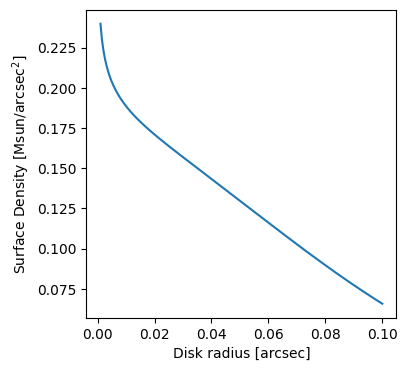

In [3]:
dist = 300 * u.pc
mstar = 0.25 * u.solMass
gamma = 0.1
mgas = 6 * 10**(-3) * u.solMass
# rc = 160 * u.au
rc = (33*u.au).value / dist.to(u.pc).value * u.arcsec

nrs = 200
rmax = 0.1 # arcsec
rmin = 0.001 # arcsec
rs = np.linspace(rmin, rmax, nrs) # arcsec
rstep = (rmax-rmin) / nrs
raus = rs * dist.to(u.pc).value * u.au

surfdenss = np.array([
    surfdens_func(
        r*u.arcsec, # / dist.to(u.pc).value * u.arcsec,
        gamma=gamma,
        mgas=mgas,
        #rc=rc.to(u.au).value / dist.to(u.pc).value * u.arcsec
        rc=rc,
    ).value
    for r in rs
])

vphis = np.array([
    vphi_func(r, mstar=mstar).to(u.km/u.s).value
    for r in raus
])

fig = plt.figure(figsize=(4,4))
ax = plt.subplot()

ax.plot(rs, surfdenss)
ax.set_xlabel("Disk radius [arcsec]")
ax.set_ylabel(r"Surface Density [Msun/arcsec$^2$]")

Text(0, 0.5, 'Velocity [km/s]')

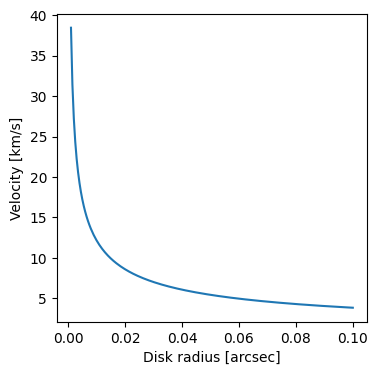

In [4]:
fig = plt.figure(figsize=(4,4))
ax = plt.subplot()

ax.plot(rs, vphis)
ax.set_xlabel("Disk radius [arcsec]")
ax.set_ylabel(r"Velocity [km/s]")


In [6]:
dist = 300 * u.pc

nrs = 80
rmax = 0.1 # arcsec
rmin = 0.01 # arcsec
rs = np.linspace(rmin, rmax, nrs) # arcsec
rstep = (rmax-rmin) / nrs
raus = rs * dist.to(u.pc).value * u.au

phistepfactor = 1

nxs = 75 # pixs
nys = 75 # pixs
xpmax = 0.25 # arcsec
arcsecpix = xpmax / nxs

velmax = 7 # kms
velmin = -7 # kms
chanwidth = 0.107
vchans = np.arange(velmin, velmax, chanwidth) # in kms
nchans = len(vchans) # chans
vt = chanwidth * 2.

mstar = 0.25 * u.solMass
gamma = 0.1
mgas = 6 * 10**(-3) * u.solMass
# rc = 160 * u.au
rc = (33*u.au).value / dist.to(u.pc).value * u.arcsec
iangle = 25 * np.pi / 180

vphis = np.array([
    vphi_func(r, mstar=mstar).to(u.km/u.s).value
    for r in raus
])

surfdenss = np.array([
    surfdens_func(
        r*u.arcsec, # / dist.to(u.pc).value * u.arcsec,
        gamma=gamma,
        mgas=mgas,
        #rc=rc.to(u.au).value / dist.to(u.pc).value * u.arcsec
        rc=rc,
    ).value
    for r in rs
])

projsurfdenss = surfdenss / np.sin(iangle)

cube = np.zeros((nchans, nys, nxs))
ci = np.cos(iangle)
si = np.sin(iangle)

#dxpixs = xpixcoords - xpixs 
#dypixs = ypixcoords - ypixs 

for ir, r in enumerate(rs):
    print(f"Computing: Radius = {r:.4f} au, Rot. velocity = {vphis[ir]:.4f} km/s")
    nphis = int(np.round(nrs * rmax / r * 2 * np.pi * phistepfactor))
    phis = np.linspace(0, 2*np.pi, nphis)
    phistep = 2*np.pi / nphis
    for iphi, phi in enumerate(phis[:-1]):
        xp = r * np.cos(phi) * ci
        yp = r * np.sin(phi)

        vzp = vphis[ir] * np.sin(phi) * si
        surf = r * phistep  * rstep
         
        xpixcoord = xp / arcsecpix + nxs/2
        ypixcoord = yp / arcsecpix + nys/2       
        xpix = int(xpixcoord)
        ypix = int(ypixcoord)
        dxpix = xpixcoord - xpix
        dypix = ypixcoord - ypix       
        for chan, vchan in enumerate(vchans):
            em = projsurfdenss[ir] * surf * np.exp(-((vzp-vchan)/vt)**2)     
            if (xpix+1<nxs) and (ypix+1<nys):
                cube[chan, ypix, xpix] += em*(1-dxpix)*(1-dypix)
                cube[chan, ypix, xpix+1] += em*dxpix*(1-dypix)
                cube[chan, ypix+1, xpix] += em*(1-dxpix)*dypix
                cube[chan, ypix+1, xpix+1] += em*dxpix*dypix           

Computing: Radius = 0.0100 au, Rot. velocity = 12.1595 km/s
Computing: Radius = 0.0111 au, Rot. velocity = 11.5210 km/s
Computing: Radius = 0.0123 au, Rot. velocity = 10.9735 km/s
Computing: Radius = 0.0134 au, Rot. velocity = 10.4973 km/s
Computing: Radius = 0.0146 au, Rot. velocity = 10.0782 km/s
Computing: Radius = 0.0157 au, Rot. velocity = 9.7056 km/s
Computing: Radius = 0.0168 au, Rot. velocity = 9.3714 km/s
Computing: Radius = 0.0180 au, Rot. velocity = 9.0696 km/s
Computing: Radius = 0.0191 au, Rot. velocity = 8.7951 km/s
Computing: Radius = 0.0203 au, Rot. velocity = 8.5442 km/s
Computing: Radius = 0.0214 au, Rot. velocity = 8.3136 km/s
Computing: Radius = 0.0225 au, Rot. velocity = 8.1007 km/s
Computing: Radius = 0.0237 au, Rot. velocity = 7.9033 km/s
Computing: Radius = 0.0248 au, Rot. velocity = 7.7197 km/s
Computing: Radius = 0.0259 au, Rot. velocity = 7.5484 km/s
Computing: Radius = 0.0271 au, Rot. velocity = 7.3880 km/s
Computing: Radius = 0.0282 au, Rot. velocity = 7.23

In [7]:
now = datetime.now().strftime("%y%m%d-%H%M%S")
hour = datetime.now().strftime("%y%m%d-%H")
today = datetime.now().strftime("%y%m%d")

pars = {
    "foldername": f"prueba_borrar",   
    "outname": 'vchan', 
    "vsys": 0,
    "pabeam": 0,
    "ybeamC10": 0.047,
    "xbeamC10": 0.03,
    "ybeamC3": 0.15,
    "xbeamC3": 0.08,
    "arcsecpix": arcsecpix,
    "pa_rotate": 0,
}
pars["x_FWHMC3"] = pars["xbeamC3"] / pars["arcsecpix"]
pars["y_FWHMC3"] = pars["ybeamC3"] / pars["arcsecpix"]
pars["x_FWHMC10"] = pars["xbeamC10"] / pars["arcsecpix"]
pars["y_FWHMC10"] = pars["ybeamC10"] / pars["arcsecpix"]

In [8]:
cubes = {}
cubes["td"] = cube

In [9]:

cks = [
    "td_r",
    "td_ri",
    "td_rcC3",
    "td_ricC3",
    "td_rcC10",
    "td_ricC10",
    "td_rcr",
#    "bs_srn",
#    "bs_srnc",
#    "bs_srncr",
]

for ck in cks:
    cubes[ck] = np.zeros_like(cubes["td"])
for chan in range(np.shape(cubes["td"])[0]):    
    # Rotate
    if "td_r" in cks:
        cubes["td_r"][chan] = rotate(cubes["td"][chan],
                             angle=pars["pa_rotate"]-90,
                             reshape=False,
                             order=1)
    if "td_ri" in cks:
        intensfactor = 1.8 * 10**19
        cubes["td_ri"][chan] = rotate(cubes["td"][chan],
                             angle=pars["pa_rotate"]-90,
                             reshape=False,
                             order=1) * intensfactor
    
    # Convolve Cycle 3
    if "td_rcC3" in cks:
        cubes["td_rcC3"][chan], testkernel = bs.gaussconvolve(cubes["td_r"][chan],
                                   x_FWHM=pars["x_FWHMC3"],
                                   y_FWHM=pars["y_FWHMC3"],
                                   pa=pars["pabeam"], return_kernel=True)   
        
    if "td_ricC3" in cks:
        beamarea_arcsec = mf.mb_sa_gaussian_f(
            pars["x_FWHMC3"]*u.arcsec,
            pars["y_FWHMC3"]*u.arcsec).to(u.arcsec**2).value
        cubes["td_ricC3"][chan], testkernel = bs.gaussconvolve(cubes["td_ri"][chan],
                                   x_FWHM=pars["x_FWHMC3"],
                                   y_FWHM=pars["y_FWHMC3"],
                                   pa=pars["pabeam"], return_kernel=True)  
        cubes["td_ricC3"][chan] = cubes["td_ricC3"][chan] * beamarea_arcsec
        
        
    # Convolve Cycle 10
    if "td_rcC10" in cks:
        cubes["td_rcC10"][chan], testkernel = bs.gaussconvolve(cubes["td_r"][chan],
                                   x_FWHM=pars["x_FWHMC10"],
                                   y_FWHM=pars["y_FWHMC10"],
                                   pa=pars["pabeam"], return_kernel=True)          
            
    # Convolve Cycle 10
    if "td_ricC10" in cks:
        beamarea_arcsec = mf.mb_sa_gaussian_f(
            pars["x_FWHMC10"]*u.arcsec,
            pars["y_FWHMC10"]*u.arcsec).to(u.arcsec**2).value              
        cubes["td_ricC10"][chan], testkernel = bs.gaussconvolve(cubes["td_ri"][chan],
                                   x_FWHM=pars["x_FWHMC10"],
                                   y_FWHM=pars["y_FWHMC10"],
                                   pa=pars["pabeam"], return_kernel=True)                 
        cubes["td_ricC10"][chan] = cubes["td_ricC10"][chan] * beamarea_arcsec       
        
    # Rotate for PV
    if "td_rcC10r" in cks:
        cubes["td_rcC10r"][chan] = rotate(cubes["td_rcC10"][chan],
                                     angle=-(pars["pa_rotate"]-90),
                                     reshape=False,
                                     order=1)       

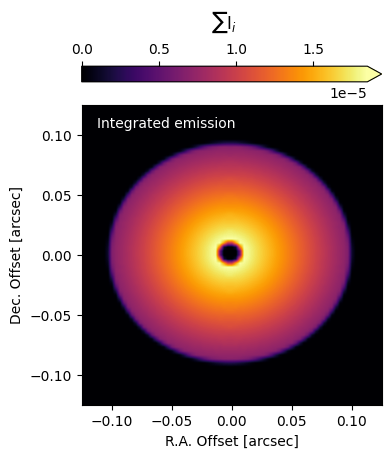

In [10]:
bk = f"td_r"
wspace = 0.0
hspace = 0.1
height_ratios = [0.05, 1]
width_ratios = [1]
figscale = 3

fig = plt.figure(figsize=(figscale*(np.sum(width_ratios)+wspace), 
                          figscale*(np.sum(height_ratios)+hspace)))
gs = GridSpec(2, 1, 
              height_ratios=height_ratios,
              width_ratios=width_ratios)

gs.update(left=0, right=1,
          bottom=0, top=1,
          wspace=wspace, hspace=hspace)

ax = plt.subplot(gs[1, 0], )
cbax = plt.subplot(gs[0, 0])

#_ = bs.sumint_plot(cubes[bk], ax, cbax, pars, fmaxlim=1, fvcenter=0.5)
im = ax.imshow(
        np.sum(cubes[bk], axis=0),
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        cmap="inferno", 
        interpolation="bilinear"
    )
plt.colorbar(im, cax=cbax, orientation="horizontal", extend="max",)
cbax.tick_params(axis="x", top=True, bottom=False, labelbottom=False,
                 labeltop=True,)
cbax.set_xlabel(r"$\sum\mathrm{I}_i$", labelpad=10, fontsize=12)
cbax.xaxis.set_label_position("top")
 
ax.text(0.05, 0.925, f"Integrated emission", color="w", transform=ax.transAxes)

ax.set_xlabel("R.A. Offset [arcsec]")
ax.set_ylabel("Dec. Offset [arcsec]")

fig.savefig(f'{bk}.pdf',
            bbox_inches="tight")

/home/guille/py_envs/radio310/lib/python3.10/svs13py/moments.py:21: RuntimeWarning: invalid value encountered in divide
  return sumIixvi(cube, chan_vels, chan_range) / sumint(cube, chan_range)


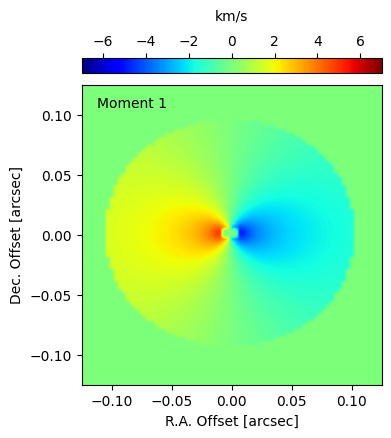

In [11]:
bk = "td_r"
bg = False
clipping = 0

wspace = 0.0
hspace = 0.05
height_ratios = [0.05, 1]
width_ratios = [1]
figscale = 3

fig = plt.figure(figsize=(figscale*(np.sum(width_ratios)+wspace), 
                          figscale*(np.sum(height_ratios)+hspace)))
gs = GridSpec(2, 1, 
              height_ratios=height_ratios,
              width_ratios=width_ratios)

gs.update(left=0, right=1,
          bottom=0, top=1,
          wspace=wspace, hspace=hspace)

ax = plt.subplot(gs[1, 0])
cbax = plt.subplot(gs[0, 0])
cmap_ref = "jet_r"
if type(cmap_ref) is str:
    cmap = cm.get_cmap(cmap_ref, 256)
else:
    cmap = cmap_ref
velcolors = cmap(np.linspace(0, 1, 256))
if bg == "black":
    bgcolor = np.array([0/256, 0/256, 0/256, 1])
    velcolors[:1, :] = bgcolor
elif bg == "white":
    bgcolor = np.array([256/256, 256/256, 256/256, 1])
    velcolors[:1, :] = bgcolor   
else:
    pass

velcmap = ListedColormap(velcolors)

velcenter = velmax+velmin
chan0 = 0
chanf = np.shape(cubes[bk])[0]
cube_clipped = np.copy(cubes[bk])
cube_clipped[cube_clipped<clipping] = 0
data = np.nan_to_num(
          moments.mom1(
             cube_clipped,
             chan_vels=vchans,
             chan_range=[chan0, chanf])
             )

velcmap = ListedColormap(velcolors[::-1])
im = ax.imshow(
    data,
    extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
    origin="lower",
    norm=TwoSlopeNorm(vmin=velmin, vcenter=velcenter, vmax=velmax),
    cmap=velcmap,
    interpolation="bilinear",
)

ax.text(0.05, 0.925, f"Moment 1", color="k", transform=ax.transAxes)

plt.colorbar(im, cax=cbax, orientation="horizontal",)
cbax.tick_params(axis="x", top=True, bottom=False, labelbottom=False,
                 labeltop=True,)
cbax.set_xlabel(r"km/s", labelpad=10, fontsize=10)
cbax.xaxis.set_label_position("top")

ax.set_xlabel("R.A. Offset [arcsec]")
ax.set_ylabel("Dec. Offset [arcsec]")

# bs.make_folder(foldername=f'{pars["foldername"]}/moments')      
fig.savefig(f'mom1_{bk}.pdf',
            bbox_inches="tight")

Text(0, 0.5, 'Dec. Offset [arcsec]')

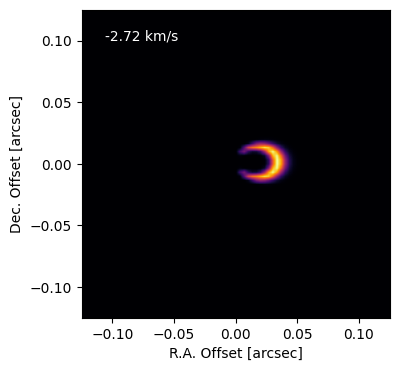

In [12]:
bk = f"td_r"

chan = 40
vchan = vchans[chan]

fig = plt.figure(figsize=(4,4))
ax = plt.subplot()

ax.imshow(
    cubes[bk][chan],
    origin="lower",
    extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
    interpolation="bilinear",
    cmap="inferno",
)

ax.text(0.075, 0.9, f"{vchan:.2f} km/s", color="w", transform=ax.transAxes)

ax.set_xlabel("R.A. Offset [arcsec]")
ax.set_ylabel("Dec. Offset [arcsec]")


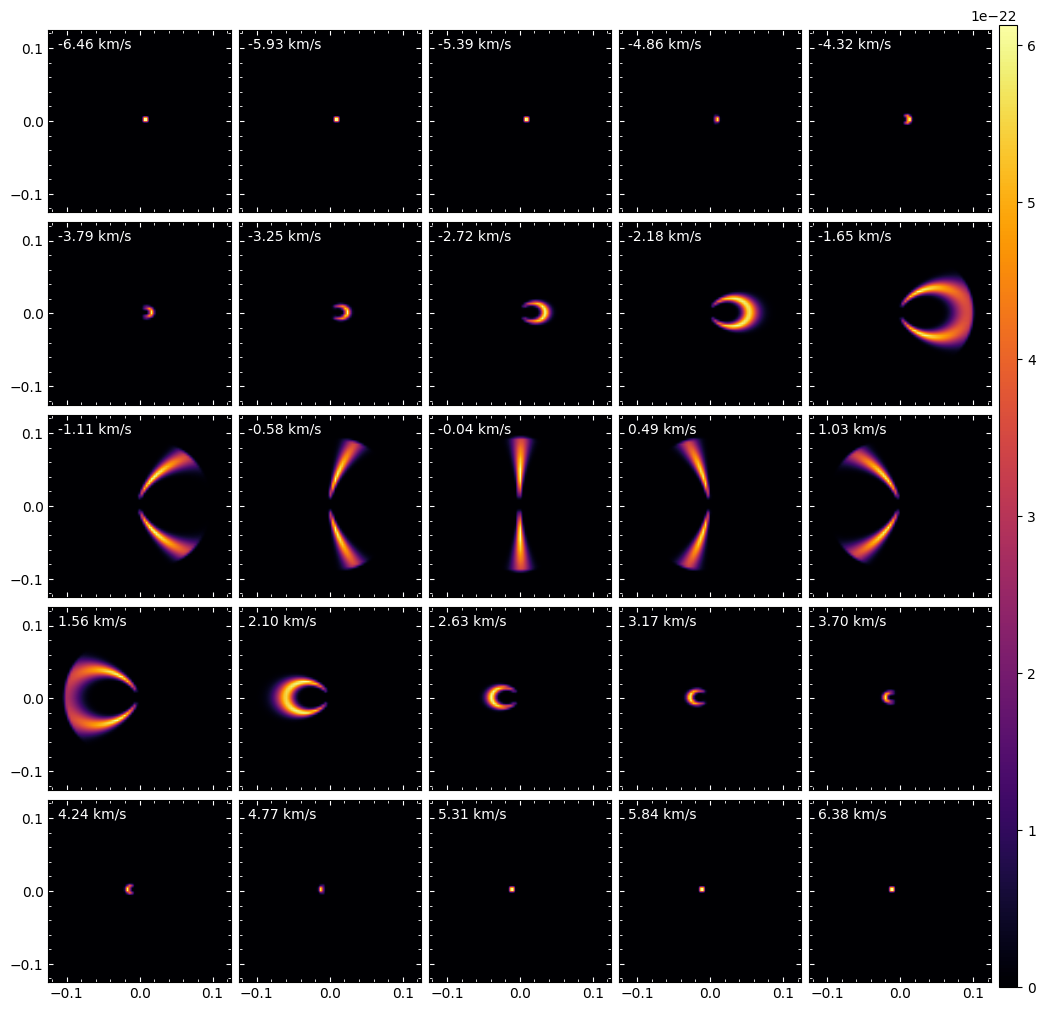

In [13]:
bk = "td_r"
#kopstr = re.findall("o\d+", bk)
#if kopstr != []:
#    kop = float(kopstr[0].lstrip("o"))
#else:
#    kop = 0

ncol = 5
nrow = 5
wspace = 0.05
hspace = 0.0

size_factor = 2.5
figsize = (ncol*size_factor, nrow*size_factor)
fig = plt.figure(figsize=figsize)
gs = GridSpec(nrow, ncol+1, 
              height_ratios=[1]*nrow,
              width_ratios=[1]*ncol+[0.1])

gs.update(wspace=wspace, hspace=hspace)

axs = {}
for n, (i,j) in enumerate(product(np.arange(nrow), np.arange(ncol))):
    axs[n] = plt.subplot(gs[i,j])
ax_cbar = plt.subplot(gs[:, ncol])

nchanscube = nrow*ncol
chans_plot = nchans
selint = int(chans_plot/nchanscube)
initchan = selint
alldata = cube[initchan::selint]
vmax = None
fvcenter = 0.5
if vmax is None:
    uplim = np.max(alldata)
    norm = TwoSlopeNorm(vcenter=uplim*fvcenter, vmax=uplim, vmin=0)
else:
    vmin = vmin if vmin is not None else 0
    vcenter = vcenter if vcenter is not None else (vmax - vmin) / 2.
    norm = TwoSlopeNorm(vmax=vmax, vcenter=vcenter, vmin=vmin)
    
iter_grid = [
    i for i in product(
        [i for i in range(nrow)],
        [j for j in range(ncol)]
    )
]
 
for chan, (i, j) in enumerate(iter_grid):
    data = cubes[bk][initchan::selint][chan]
    im = axs[chan].imshow(
        data,
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        interpolation="bilinear",
        cmap="inferno",
    )   
    axs[chan].set_aspect("equal")
   
    axs[chan].text(0.05, 0.9,
            s=f"{vchans[initchan::selint][chan]:.2f} km/s",
            color="w",
            transform=axs[chan].transAxes,
            fontsize=10)
    axs[chan].tick_params(
        which="both",
        top=True,
        right=True,
        direction="in",
        color="w",
    )
    axs[chan].xaxis.set_major_locator(ticker.MultipleLocator(0.1))    
    axs[chan].xaxis.set_minor_locator(ticker.MultipleLocator(0.02))    
    axs[chan].yaxis.set_major_locator(ticker.MultipleLocator(0.1))    
    axs[chan].yaxis.set_minor_locator(ticker.MultipleLocator(0.02))       
    if (j > 0) and (i < nrow-1):
        axs[chan].set_xticklabels([])
        axs[chan].set_yticklabels([])
    if (i == (nrow-1)) and (j > 0):
        axs[chan].set_yticklabels([])
    if (i < (nrow-1)) and (j == 0):
        axs[chan].set_xticklabels([])
    
plt.colorbar(im, cax=ax_cbar)

fig.savefig(f'channels_{bk}.pdf',
            bbox_inches="tight")

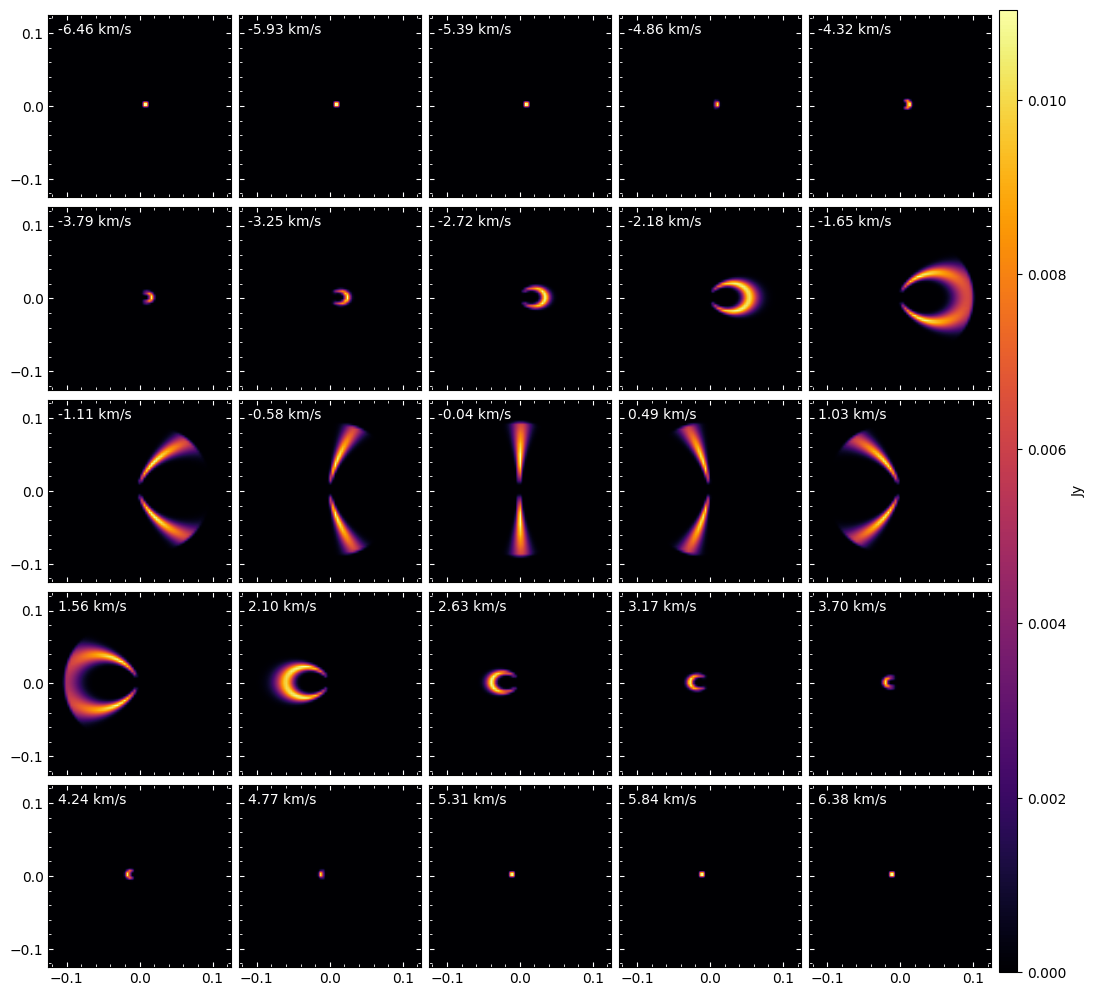

In [14]:
bk = "td_ri"
#kopstr = re.findall("o\d+", bk)
#if kopstr != []:
#    kop = float(kopstr[0].lstrip("o"))
#else:
#    kop = 0

ncol = 5
nrow = 5
wspace = 0.05
hspace = 0.0

size_factor = 2.5
figsize = (ncol*size_factor, nrow*size_factor)
fig = plt.figure(figsize=figsize)
gs = GridSpec(nrow, ncol+1, 
              height_ratios=[1]*nrow,
              width_ratios=[1]*ncol+[0.1])

gs.update(wspace=wspace, hspace=hspace)

axs = {}
for n, (i,j) in enumerate(product(np.arange(nrow), np.arange(ncol))):
    axs[n] = plt.subplot(gs[i,j])
ax_cbar = plt.subplot(gs[:, ncol])

nchanscube = nrow*ncol
chans_plot = nchans
selint = int(chans_plot/nchanscube)
initchan = selint 
alldata = cube[initchan::selint]
vmax = None
fvcenter = 0.5
if vmax is None:
    uplim = np.max(alldata)
    norm = TwoSlopeNorm(vcenter=uplim*fvcenter, vmax=uplim, vmin=0)
else:
    vmin = vmin if vmin is not None else 0
    vcenter = vcenter if vcenter is not None else (vmax - vmin) / 2.
    norm = TwoSlopeNorm(vmax=vmax, vcenter=vcenter, vmin=vmin)
    
iter_grid = [
    i for i in product(
        [i for i in range(nrow)],
        [j for j in range(ncol)]
    )
]
for chan, (i, j) in enumerate(iter_grid):
    data = cubes[bk][initchan::selint][chan]
    im = axs[chan].imshow(
        data,
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        interpolation="bilinear",
        cmap="inferno",
    )   
    axs[chan].set_aspect("equal")
   
    axs[chan].text(0.05, 0.9,
            s=f"{vchans[initchan::selint][chan]:.2f} km/s",
            color="w",
            transform=axs[chan].transAxes,
            fontsize=10)
    axs[chan].tick_params(
        which="both",
        top=True,
        right=True,
        direction="in",
        color="w",
    )
    axs[chan].xaxis.set_major_locator(ticker.MultipleLocator(0.1))    
    axs[chan].xaxis.set_minor_locator(ticker.MultipleLocator(0.02))    
    axs[chan].yaxis.set_major_locator(ticker.MultipleLocator(0.1))    
    axs[chan].yaxis.set_minor_locator(ticker.MultipleLocator(0.02))       
    if (j > 0) and (i < nrow-1):
        axs[chan].set_xticklabels([])
        axs[chan].set_yticklabels([])
    if (i == (nrow-1)) and (j > 0):
        axs[chan].set_yticklabels([])
    if (i < (nrow-1)) and (j == 0):
        axs[chan].set_xticklabels([])

plt.colorbar(im, cax=ax_cbar)
ax_cbar.set_ylabel("Jy")

fig.savefig(f'channels_{bk}.pdf',
            bbox_inches="tight")

# Convolve cycle 3

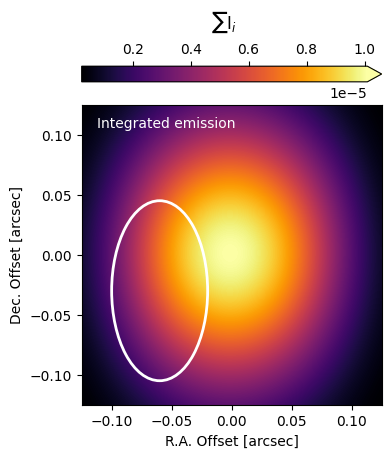

In [15]:
bk = f"td_rcC3"
wspace = 0.0
hspace = 0.1
height_ratios = [0.05, 1]
width_ratios = [1]
figscale = 3

fig = plt.figure(figsize=(figscale*(np.sum(width_ratios)+wspace), 
                          figscale*(np.sum(height_ratios)+hspace)))
gs = GridSpec(2, 1, 
              height_ratios=height_ratios,
              width_ratios=width_ratios)

gs.update(left=0, right=1,
          bottom=0, top=1,
          wspace=wspace, hspace=hspace)

ax = plt.subplot(gs[1, 0], )
cbax = plt.subplot(gs[0, 0])

#_ = bs.sumint_plot(cubes[bk], ax, cbax, pars, fmaxlim=1, fvcenter=0.5)
im = ax.imshow(
        np.sum(cubes[bk], axis=0),
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        cmap="inferno", 
        interpolation="bilinear"
    )
 
pa = pars['pabeam'] * np.pi/180. + np.pi/2
# in radians
a = pars['ybeamC3'] #/ pars['arcsecpix']
# semi-major axis in pixels
b = pars['xbeamC3'] #/ pars['arcsecpix']   #semi-minor axis in pixels
xpos = -0.06
ypos = -0.03
geometry = EllipseGeometry(x0=xpos, y0=ypos,
                           sma=a*0.5, eps=(1-b/a), pa=pa)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
   
aper.plot(ax,
          color="w",
          linewidth=2,
          transform=ax.transData)   
   
plt.colorbar(im, cax=cbax, orientation="horizontal", extend="max",)
cbax.tick_params(axis="x", top=True, bottom=False, labelbottom=False,
                 labeltop=True,)
cbax.set_xlabel(r"$\sum\mathrm{I}_i$", labelpad=10, fontsize=12)
cbax.xaxis.set_label_position("top")
 
ax.text(0.05, 0.925, f"Integrated emission", color="w", transform=ax.transAxes)

ax.set_xlabel("R.A. Offset [arcsec]")
ax.set_ylabel("Dec. Offset [arcsec]")

fig.savefig(f'{bk}.pdf',
            bbox_inches="tight")

/home/guille/py_envs/radio310/lib/python3.10/svs13py/moments.py:21: RuntimeWarning: invalid value encountered in divide
  return sumIixvi(cube, chan_vels, chan_range) / sumint(cube, chan_range)


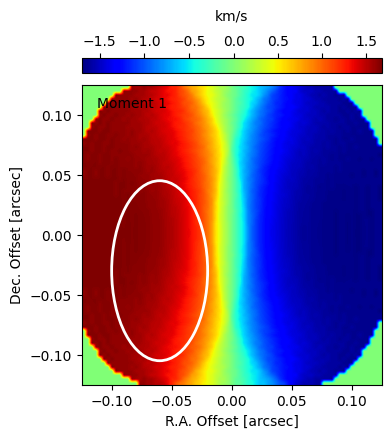

In [16]:
bk = "td_rcC3"
bg = None
clipping = 10**(-7) 

wspace = 0.0
hspace = 0.05
height_ratios = [0.05, 1]
width_ratios = [1]
figscale = 3

fig = plt.figure(figsize=(figscale*(np.sum(width_ratios)+wspace), 
                          figscale*(np.sum(height_ratios)+hspace)))
gs = GridSpec(2, 1, 
              height_ratios=height_ratios,
              width_ratios=width_ratios)

gs.update(left=0, right=1,
          bottom=0, top=1,
          wspace=wspace, hspace=hspace)

ax = plt.subplot(gs[1, 0])
cbax = plt.subplot(gs[0, 0])
cmap_ref = "jet_r"
if type(cmap_ref) is str:
    cmap = cm.get_cmap(cmap_ref, 256)
else:
    cmap = cmap_ref
velcolors = cmap(np.linspace(0, 1, 256))
if bg == "black":
    bgcolor = np.array([0/256, 0/256, 0/256, 1])
    velcolors[:1, :] = bgcolor
elif bg == "white":
    bgcolor = np.array([256/256, 256/256, 256/256, 1])
    velcolors[:1, :] = bgcolor
else:
    pass

velcmap = ListedColormap(velcolors)

chan0 = 0
chanf = np.shape(cubes[bk])[0]
cube_clipped = np.copy(cubes[bk])
cube_clipped[cube_clipped<clipping] = 0
data = np.nan_to_num(
          moments.mom1(
             cube_clipped,
             chan_vels=vchans,
             chan_range=[chan0, chanf])
             )

velcmap = ListedColormap(velcolors[::-1])
velminmom1 = np.min(data)
velmaxmom1 = np.max(data)
velcentermom1 = velmaxmom1+velminmom1
im = ax.imshow(
    data,
    extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
    origin="lower",
    norm=TwoSlopeNorm(vmin=velminmom1, vcenter=velcentermom1, vmax=velmaxmom1),
    cmap=velcmap,
    interpolation="bilinear",
)

pa = pars['pabeam'] * np.pi/180. + np.pi/2
# in radians
a = pars['ybeamC3'] #/ pars['arcsecpix']
# semi-major axis in pixels
b = pars['xbeamC3'] #/ pars['arcsecpix']   #semi-minor axis in pixels
xpos = -0.06
ypos = -0.03
geometry = EllipseGeometry(x0=xpos, y0=ypos,
                           sma=a*0.5, eps=(1-b/a), pa=pa)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
   
aper.plot(ax,
          color="w",
          linewidth=2,
          transform=ax.transData)

ax.text(0.05, 0.925, f"Moment 1", color="k", transform=ax.transAxes)

plt.colorbar(im, cax=cbax, orientation="horizontal",)
cbax.tick_params(axis="x", top=True, bottom=False, labelbottom=False,
                 labeltop=True,)
cbax.set_xlabel(r"km/s", labelpad=10, fontsize=10)
cbax.xaxis.set_label_position("top")

ax.set_xlabel("R.A. Offset [arcsec]")
ax.set_ylabel("Dec. Offset [arcsec]")

# bs.make_folder(foldername=f'{pars["foldername"]}/moments')      
fig.savefig(f'mom1_{bk}.pdf',
            bbox_inches="tight")

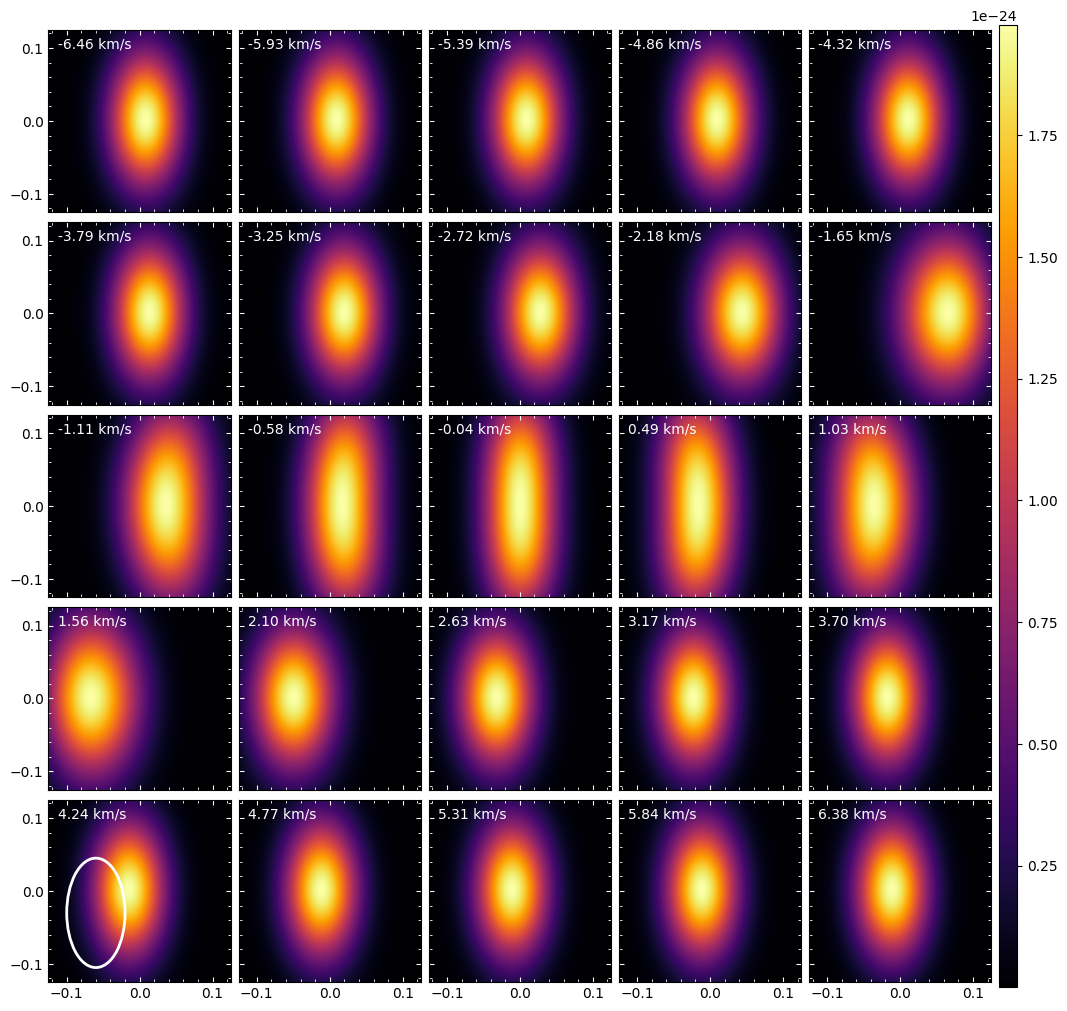

In [17]:
bk = "td_rcC3"
#kopstr = re.findall("o\d+", bk)
#if kopstr != []:
#    kop = float(kopstr[0].lstrip("o"))
#else:
#    kop = 0

ncol = 5
nrow = 5
wspace = 0.05
hspace = 0.0

size_factor = 2.5
figsize = (ncol*size_factor, nrow*size_factor)
fig = plt.figure(figsize=figsize)
gs = GridSpec(nrow, ncol+1, 
              height_ratios=[1]*nrow,
              width_ratios=[1]*ncol+[0.1])

gs.update(wspace=wspace, hspace=hspace)

axs = {}
for n, (i,j) in enumerate(product(np.arange(nrow), np.arange(ncol))):
    axs[n] = plt.subplot(gs[i,j])
ax_cbar = plt.subplot(gs[:, ncol])

nchanscube = nrow*ncol
chans_plot = nchans
selint = int(chans_plot/nchanscube)
initchan = selint 
alldata = cube[initchan::selint]
vmax = None
fvcenter = 0.5
if vmax is None:
    uplim = np.max(alldata)
    norm = TwoSlopeNorm(vcenter=uplim*fvcenter, vmax=uplim, vmin=0)
else:
    vmin = vmin if vmin is not None else 0
    vcenter = vcenter if vcenter is not None else (vmax - vmin) / 2.
    norm = TwoSlopeNorm(vmax=vmax, vcenter=vcenter, vmin=vmin)
    
iter_grid = [
    i for i in product(
        [i for i in range(nrow)],
        [j for j in range(ncol)]
    )
]
for chan, (i, j) in enumerate(iter_grid):
    data = cubes[bk][initchan::selint][chan]
    im = axs[chan].imshow(
        data,
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        interpolation="bilinear",
        cmap="inferno",
    )   
    axs[chan].set_aspect("equal")
   
    axs[chan].text(0.05, 0.9,
            s=f"{vchans[initchan::selint][chan]:.2f} km/s",
            color="w",
            transform=axs[chan].transAxes,
            fontsize=10)
    axs[chan].tick_params(
        which="both",
        top=True,
        right=True,
        direction="in",
        color="w",
    )
    axs[chan].xaxis.set_major_locator(ticker.MultipleLocator(0.1))    
    axs[chan].xaxis.set_minor_locator(ticker.MultipleLocator(0.02))    
    axs[chan].yaxis.set_major_locator(ticker.MultipleLocator(0.1))    
    axs[chan].yaxis.set_minor_locator(ticker.MultipleLocator(0.02))       
    if (j > 0) and (i < nrow-1):
        axs[chan].set_xticklabels([])
        axs[chan].set_yticklabels([])
    if (i == (nrow-1)) and (j > 0):
        axs[chan].set_yticklabels([])
    if (i < (nrow-1)) and (j == 0):
        axs[chan].set_xticklabels([])
    
pa = pars['pabeam'] * np.pi/180. + np.pi/2
# in radians
a = pars['ybeamC3'] #/ pars['arcsecpix']
# semi-major axis in pixels
b = pars['xbeamC3'] #/ pars['arcsecpix']   #semi-minor axis in pixels
xpos = -0.06
ypos = -0.03
geometry = EllipseGeometry(x0=xpos, y0=ypos,
                           sma=a*0.5, eps=(1-b/a), pa=pa)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
   
aper.plot(axs[nrow*(ncol-1)],
          color="w",
          linewidth=2,
          transform=axs[nrow*(ncol-1)].transData)
    
plt.colorbar(im, cax=ax_cbar)

fig.savefig(f'channels_{bk}.pdf',
            bbox_inches="tight")

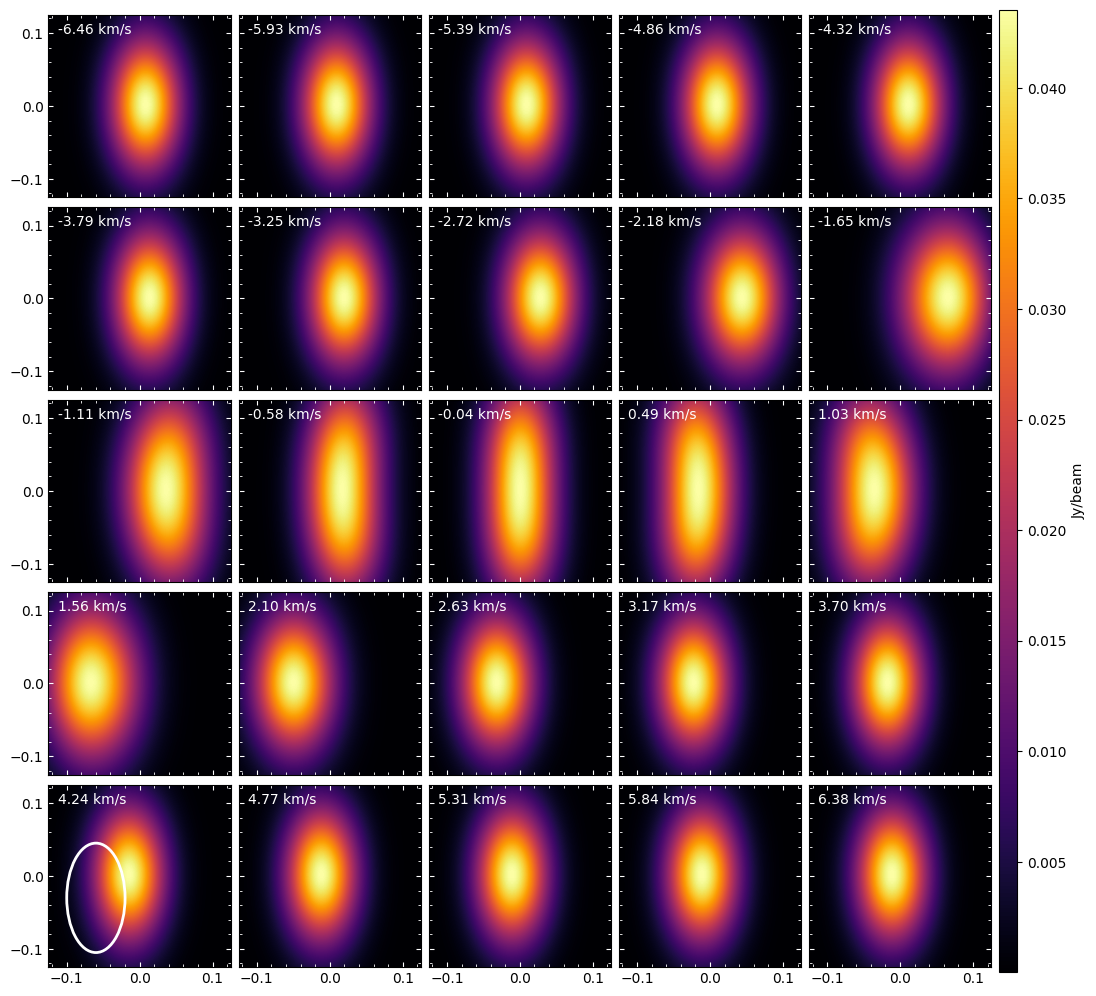

In [18]:
bk = "td_ricC3"
#kopstr = re.findall("o\d+", bk)
#if kopstr != []:
#    kop = float(kopstr[0].lstrip("o"))
#else:
#    kop = 0

ncol = 5
nrow = 5
wspace = 0.05
hspace = 0.0

size_factor = 2.5
figsize = (ncol*size_factor, nrow*size_factor)
fig = plt.figure(figsize=figsize)
gs = GridSpec(nrow, ncol+1, 
              height_ratios=[1]*nrow,
              width_ratios=[1]*ncol+[0.1])

gs.update(wspace=wspace, hspace=hspace)

axs = {}
for n, (i,j) in enumerate(product(np.arange(nrow), np.arange(ncol))):
    axs[n] = plt.subplot(gs[i,j])
ax_cbar = plt.subplot(gs[:, ncol])

nchanscube = nrow*ncol
chans_plot = nchans
selint = int(chans_plot/nchanscube)
initchan = selint 
alldata = cube[initchan::selint]
vmax = None
fvcenter = 0.5
if vmax is None:
    uplim = np.max(alldata)
    norm = TwoSlopeNorm(vcenter=uplim*fvcenter, vmax=uplim, vmin=0)
else:
    vmin = vmin if vmin is not None else 0
    vcenter = vcenter if vcenter is not None else (vmax - vmin) / 2.
    norm = TwoSlopeNorm(vmax=vmax, vcenter=vcenter, vmin=vmin)
    
iter_grid = [
    i for i in product(
        [i for i in range(nrow)],
        [j for j in range(ncol)]
    )
]
for chan, (i, j) in enumerate(iter_grid):
    data = cubes[bk][initchan::selint][chan]
    im = axs[chan].imshow(
        data,
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        interpolation="bilinear",
        cmap="inferno",
    )   
    axs[chan].set_aspect("equal")
   
    axs[chan].text(0.05, 0.9,
            s=f"{vchans[initchan::selint][chan]:.2f} km/s",
            color="w",
            transform=axs[chan].transAxes,
            fontsize=10)
    axs[chan].tick_params(
        which="both",
        top=True,
        right=True,
        direction="in",
        color="w",
    )
    axs[chan].xaxis.set_major_locator(ticker.MultipleLocator(0.1))    
    axs[chan].xaxis.set_minor_locator(ticker.MultipleLocator(0.02))    
    axs[chan].yaxis.set_major_locator(ticker.MultipleLocator(0.1))    
    axs[chan].yaxis.set_minor_locator(ticker.MultipleLocator(0.02))       
    if (j > 0) and (i < nrow-1):
        axs[chan].set_xticklabels([])
        axs[chan].set_yticklabels([])
    if (i == (nrow-1)) and (j > 0):
        axs[chan].set_yticklabels([])
    if (i < (nrow-1)) and (j == 0):
        axs[chan].set_xticklabels([])
    
pa = pars['pabeam'] * np.pi/180. + np.pi/2
# in radians
a = pars['ybeamC3'] #/ pars['arcsecpix']
# semi-major axis in pixels
b = pars['xbeamC3'] #/ pars['arcsecpix']   #semi-minor axis in pixels
xpos = -0.06
ypos = -0.03
geometry = EllipseGeometry(x0=xpos, y0=ypos,
                           sma=a*0.5, eps=(1-b/a), pa=pa)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
   
aper.plot(axs[nrow*(ncol-1)],
          color="w",
          linewidth=2,
          transform=axs[nrow*(ncol-1)].transData)
    
plt.colorbar(im, cax=ax_cbar)
ax_cbar.set_ylabel("Jy/beam")

fig.savefig(f'channels_{bk}.pdf',
            bbox_inches="tight")

# Cycle 10

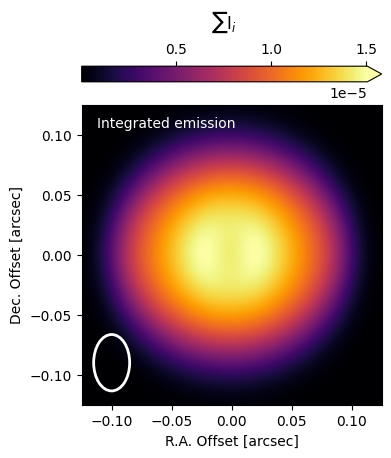

In [19]:
bk = f"td_rcC10"
wspace = 0.0
hspace = 0.1
height_ratios = [0.05, 1]
width_ratios = [1]
figscale = 3

fig = plt.figure(figsize=(figscale*(np.sum(width_ratios)+wspace), 
                          figscale*(np.sum(height_ratios)+hspace)))
gs = GridSpec(2, 1, 
              height_ratios=height_ratios,
              width_ratios=width_ratios)

gs.update(left=0, right=1,
          bottom=0, top=1,
          wspace=wspace, hspace=hspace)

ax = plt.subplot(gs[1, 0], )
cbax = plt.subplot(gs[0, 0])

#_ = bs.sumint_plot(cubes[bk], ax, cbax, pars, fmaxlim=1, fvcenter=0.5)
im = ax.imshow(
        np.sum(cubes[bk], axis=0),
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        cmap="inferno", 
        interpolation="bilinear"
    )

pa = pars['pabeam'] * np.pi/180. + np.pi/2
# in radians
a = pars['ybeamC10'] #/ pars['arcsecpix']
# semi-major axis in pixels
b = pars['xbeamC10'] #/ pars['arcsecpix']   #semi-minor axis in pixels
xpos = -0.1
ypos = -0.09
geometry = EllipseGeometry(x0=xpos, y0=ypos,
                           sma=a*0.5, eps=(1-b/a), pa=pa)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
   
aper.plot(ax,
          color="w",
          linewidth=2,
          transform=ax.transData)

plt.colorbar(im, cax=cbax, orientation="horizontal", extend="max",)
cbax.tick_params(axis="x", top=True, bottom=False, labelbottom=False,
                 labeltop=True,)
cbax.set_xlabel(r"$\sum\mathrm{I}_i$", labelpad=10, fontsize=12)
cbax.xaxis.set_label_position("top")
 
ax.text(0.05, 0.925, f"Integrated emission", color="w", transform=ax.transAxes)

ax.set_xlabel("R.A. Offset [arcsec]")
ax.set_ylabel("Dec. Offset [arcsec]")

fig.savefig(f'{bk}.pdf',
            bbox_inches="tight")

/home/guille/py_envs/radio310/lib/python3.10/svs13py/moments.py:21: RuntimeWarning: invalid value encountered in divide
  return sumIixvi(cube, chan_vels, chan_range) / sumint(cube, chan_range)


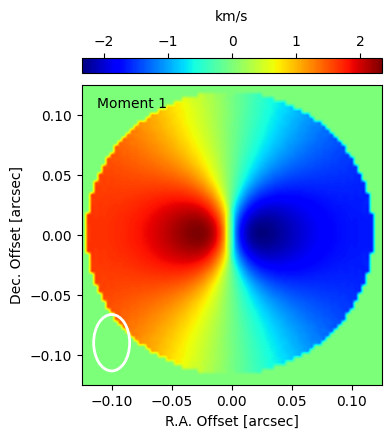

In [20]:
bk = "td_rcC10"
bg = None
clipping = 10**(-7) 

wspace = 0.0
hspace = 0.05
height_ratios = [0.05, 1]
width_ratios = [1]
figscale = 3

fig = plt.figure(figsize=(figscale*(np.sum(width_ratios)+wspace), 
                          figscale*(np.sum(height_ratios)+hspace)))
gs = GridSpec(2, 1, 
              height_ratios=height_ratios,
              width_ratios=width_ratios)

gs.update(left=0, right=1,
          bottom=0, top=1,
          wspace=wspace, hspace=hspace)

ax = plt.subplot(gs[1, 0])
cbax = plt.subplot(gs[0, 0])
cmap_ref = "jet_r"
if type(cmap_ref) is str:
    cmap = cm.get_cmap(cmap_ref, 256)
else:
    cmap = cmap_ref
velcolors = cmap(np.linspace(0, 1, 256))
if bg == "black":
    bgcolor = np.array([0/256, 0/256, 0/256, 1])
    velcolors[:1, :] = bgcolor
elif bg == "white":
    bgcolor = np.array([256/256, 256/256, 256/256, 1])
    velcolors[:1, :] = bgcolor
else:
    pass

velcmap = ListedColormap(velcolors)

chan0 = 0
chanf = np.shape(cubes[bk])[0]
cube_clipped = np.copy(cubes[bk])
cube_clipped[cube_clipped<clipping] = 0
data = np.nan_to_num(
          moments.mom1(
             cube_clipped,
             chan_vels=vchans,
             chan_range=[chan0, chanf])
             )

velcmap = ListedColormap(velcolors[::-1])
velminmom1 = np.min(data)
velmaxmom1 = np.max(data)
velcentermom1 = velmaxmom1+velminmom1
im = ax.imshow(
    data,
    extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
    origin="lower",
    norm=TwoSlopeNorm(vmin=velminmom1, vcenter=velcentermom1, vmax=velmaxmom1),
    cmap=velcmap,
    interpolation="bilinear",
)

pa = pars['pabeam'] * np.pi/180. + np.pi/2
# in radians
a = pars['ybeamC10'] #/ pars['arcsecpix']
# semi-major axis in pixels
b = pars['xbeamC10'] #/ pars['arcsecpix']   #semi-minor axis in pixels
xpos = -0.1
ypos = -0.09
geometry = EllipseGeometry(x0=xpos, y0=ypos,
                           sma=a*0.5, eps=(1-b/a), pa=pa)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
   
aper.plot(ax,
          color="w",
          linewidth=2,
          transform=ax.transData)

ax.text(0.05, 0.925, f"Moment 1", color="k", transform=ax.transAxes)

plt.colorbar(im, cax=cbax, orientation="horizontal",)
cbax.tick_params(axis="x", top=True, bottom=False, labelbottom=False,
                 labeltop=True,)
cbax.set_xlabel(r"km/s", labelpad=10, fontsize=10)
cbax.xaxis.set_label_position("top")

ax.set_xlabel("R.A. Offset [arcsec]")
ax.set_ylabel("Dec. Offset [arcsec]")

# bs.make_folder(foldername=f'{pars["foldername"]}/moments')      
fig.savefig(f'mom1_{bk}.pdf',
            bbox_inches="tight")

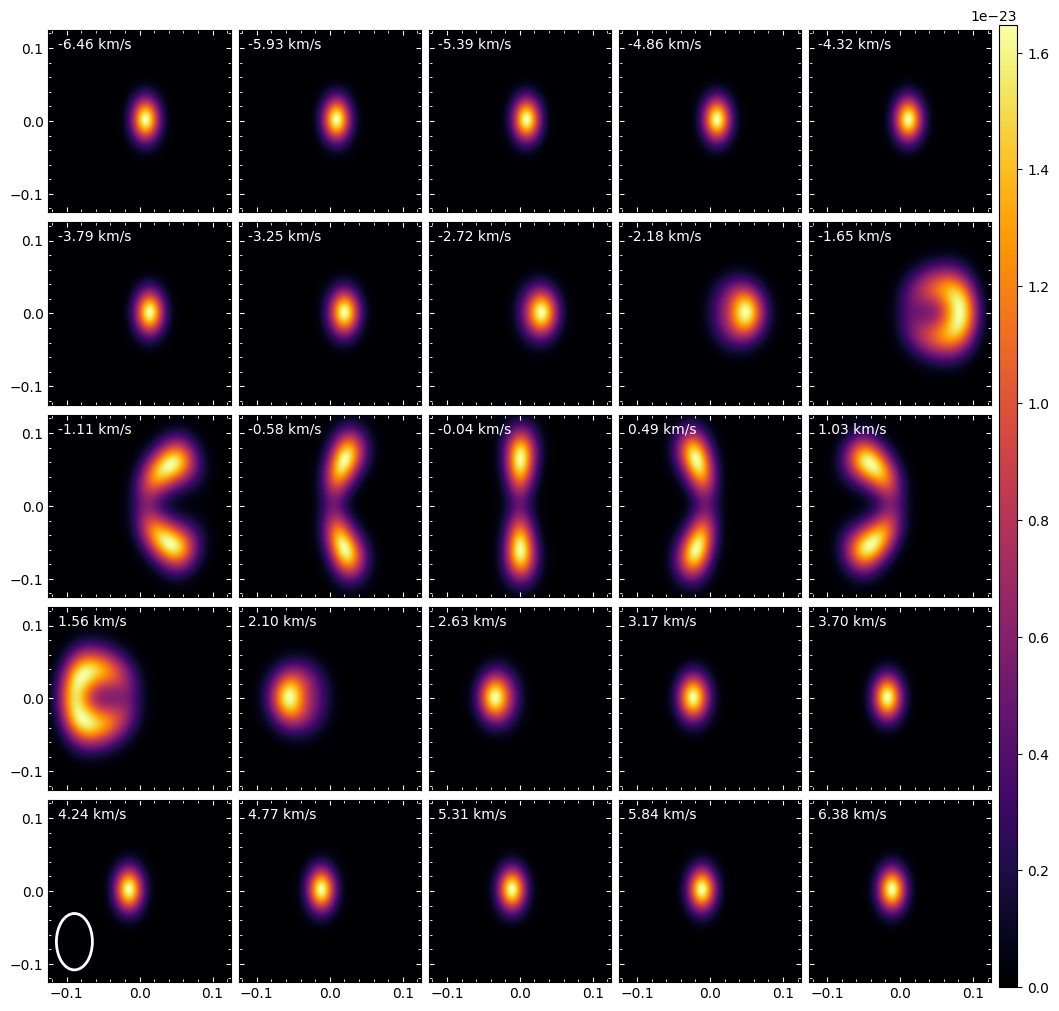

In [21]:
bk = "td_rcC10"
#kopstr = re.findall("o\d+", bk)
#if kopstr != []:
#    kop = float(kopstr[0].lstrip("o"))
#else:
#    kop = 0

ncol = 5
nrow = 5
wspace = 0.05
hspace = 0.0

size_factor = 2.5
figsize = (ncol*size_factor, nrow*size_factor)
fig = plt.figure(figsize=figsize)
gs = GridSpec(nrow, ncol+1, 
              height_ratios=[1]*nrow,
              width_ratios=[1]*ncol+[0.1])

gs.update(wspace=wspace, hspace=hspace)

axs = {}
for n, (i,j) in enumerate(product(np.arange(nrow), np.arange(ncol))):
    axs[n] = plt.subplot(gs[i,j])
ax_cbar = plt.subplot(gs[:, ncol])

nchanscube = nrow*ncol
chans_plot = nchans
selint = int(chans_plot/nchanscube)
initchan = selint 
alldata = cube[initchan::selint]
vmax = None
fvcenter = 0.5
if vmax is None:
    uplim = np.max(alldata)
    norm = TwoSlopeNorm(vcenter=uplim*fvcenter, vmax=uplim, vmin=0)
else:
    vmin = vmin if vmin is not None else 0
    vcenter = vcenter if vcenter is not None else (vmax - vmin) / 2.
    norm = TwoSlopeNorm(vmax=vmax, vcenter=vcenter, vmin=vmin)
    
iter_grid = [
    i for i in product(
        [i for i in range(nrow)],
        [j for j in range(ncol)]
    )
]
for chan, (i, j) in enumerate(iter_grid):
    data = cubes[bk][initchan::selint][chan]
    im = axs[chan].imshow(
        data,
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        interpolation="bilinear",
        cmap="inferno",
    )   
    axs[chan].set_aspect("equal")
   
    axs[chan].text(0.05, 0.9,
            s=f"{vchans[initchan::selint][chan]:.2f} km/s",
            color="w",
            transform=axs[chan].transAxes,
            fontsize=10)
    axs[chan].tick_params(
        which="both",
        top=True,
        right=True,
        direction="in",
        color="w",
    )
    axs[chan].xaxis.set_major_locator(ticker.MultipleLocator(0.1))    
    axs[chan].xaxis.set_minor_locator(ticker.MultipleLocator(0.02))    
    axs[chan].yaxis.set_major_locator(ticker.MultipleLocator(0.1))    
    axs[chan].yaxis.set_minor_locator(ticker.MultipleLocator(0.02))       
    if (j > 0) and (i < nrow-1):
        axs[chan].set_xticklabels([])
        axs[chan].set_yticklabels([])
    if (i == (nrow-1)) and (j > 0):
        axs[chan].set_yticklabels([])
    if (i < (nrow-1)) and (j == 0):
        axs[chan].set_xticklabels([])
    
pa = pars['pabeam'] * np.pi/180. + np.pi/2
# in radians
a = pars['ybeamC10'] #/ pars['arcsecpix']
# semi-major axis in pixels
b = pars['xbeamC10'] #/ pars['arcsecpix']   #semi-minor axis in pixels
xpos = -0.063
ypos = -0.07
geometry = EllipseGeometry(x0=xpos, y0=ypos,
                           sma=a*0.5, eps=(1-b/a), pa=pa)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                          
                           geometry.pa)
   
for n in axs:
    aper.plot(axs[n], color="w", linewidth=2, transform=ax.transData)
    
plt.colorbar(im, cax=ax_cbar)

fig.savefig(f'channels_{bk}.pdf',
            bbox_inches="tight")

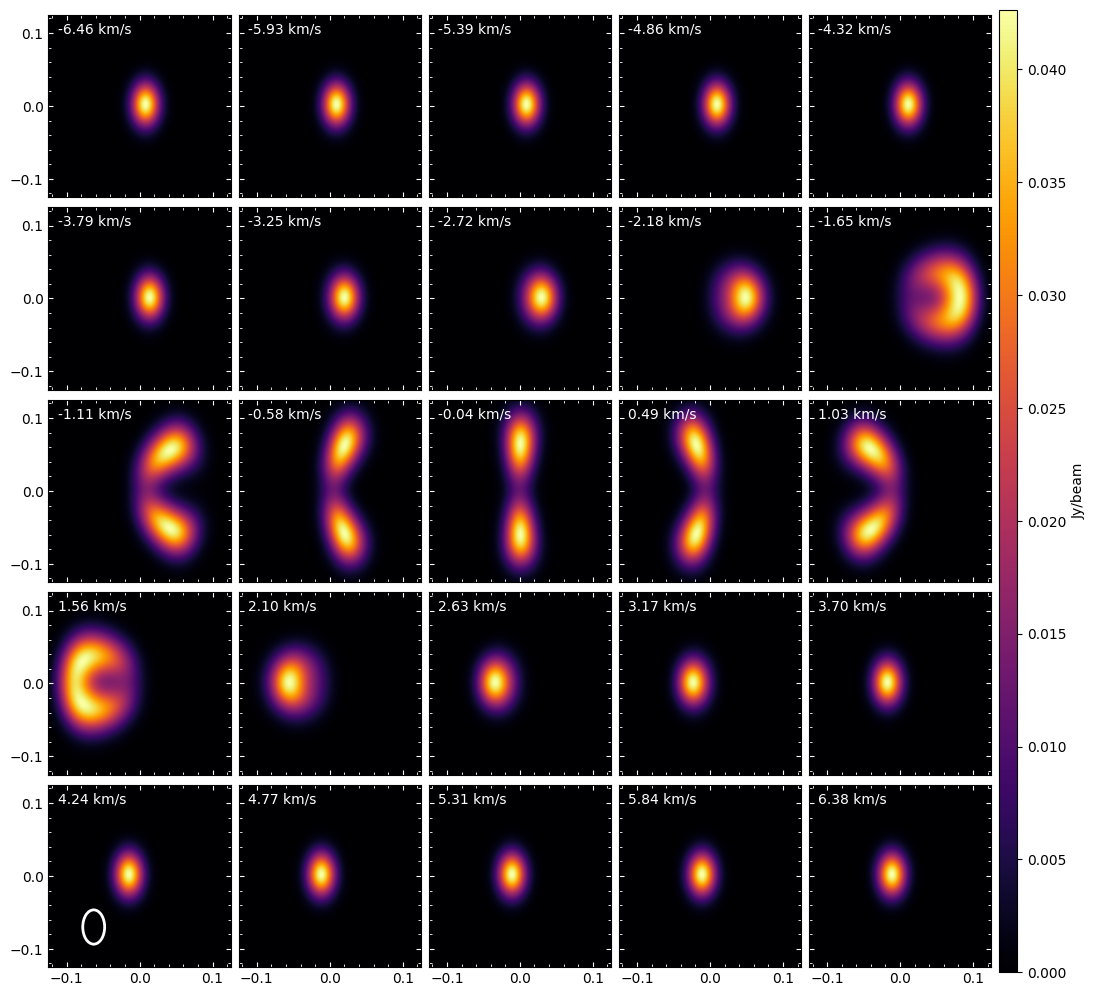

In [22]:
bk = "td_ricC10"
#kopstr = re.findall("o\d+", bk)
#if kopstr != []:
#    kop = float(kopstr[0].lstrip("o"))
#else:
#    kop = 0

ncol = 5
nrow = 5
wspace = 0.05
hspace = 0.0

size_factor = 2.5
figsize = (ncol*size_factor, nrow*size_factor)
fig = plt.figure(figsize=figsize)
gs = GridSpec(nrow, ncol+1, 
              height_ratios=[1]*nrow,
              width_ratios=[1]*ncol+[0.1])

gs.update(wspace=wspace, hspace=hspace)

axs = {}
for n, (i,j) in enumerate(product(np.arange(nrow), np.arange(ncol))):
    axs[n] = plt.subplot(gs[i,j])
ax_cbar = plt.subplot(gs[:, ncol])

nchanscube = nrow*ncol
chans_plot = nchans
selint = int(chans_plot/nchanscube)
initchan = selint 
alldata = cube[initchan::selint]
vmax = None
fvcenter = 0.5
if vmax is None:
    uplim = np.max(alldata)
    norm = TwoSlopeNorm(vcenter=uplim*fvcenter, vmax=uplim, vmin=0)
else:
    vmin = vmin if vmin is not None else 0
    vcenter = vcenter if vcenter is not None else (vmax - vmin) / 2.
    norm = TwoSlopeNorm(vmax=vmax, vcenter=vcenter, vmin=vmin)
    
iter_grid = [
    i for i in product(
        [i for i in range(nrow)],
        [j for j in range(ncol)]
    )
]
for chan, (i, j) in enumerate(iter_grid):
    data = cubes[bk][initchan::selint][chan]
    im = axs[chan].imshow(
        data,
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        interpolation="bilinear",
        cmap="inferno",
    )   
    axs[chan].set_aspect("equal")
   
    axs[chan].text(0.05, 0.9,
            s=f"{vchans[initchan::selint][chan]:.2f} km/s",
            color="w",
            transform=axs[chan].transAxes,
            fontsize=10)
    axs[chan].tick_params(
        which="both",
        top=True,
        right=True,
        direction="in",
        color="w",
    )
    axs[chan].xaxis.set_major_locator(ticker.MultipleLocator(0.1))    
    axs[chan].xaxis.set_minor_locator(ticker.MultipleLocator(0.02))    
    axs[chan].yaxis.set_major_locator(ticker.MultipleLocator(0.1))    
    axs[chan].yaxis.set_minor_locator(ticker.MultipleLocator(0.02))       
    if (j > 0) and (i < nrow-1):
        axs[chan].set_xticklabels([])
        axs[chan].set_yticklabels([])
    if (i == (nrow-1)) and (j > 0):
        axs[chan].set_yticklabels([])
    if (i < (nrow-1)) and (j == 0):
        axs[chan].set_xticklabels([])
    
pa = pars['pabeam'] * np.pi/180. + np.pi/2
# in radians
a = pars['ybeamC10'] #/ pars['arcsecpix']
# semi-major axis in pixels
b = pars['xbeamC10'] #/ pars['arcsecpix']   #semi-minor axis in pixels
xpos = -0.063
ypos = -0.07
geometry = EllipseGeometry(x0=xpos, y0=ypos,
                           sma=a*0.5, eps=(1-b/a), pa=pa)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
   
aper.plot(axs[nrow*(ncol-1)],
          color="w",
          linewidth=2,
          transform=axs[nrow*(ncol-1)].transData)
    
plt.colorbar(im, cax=ax_cbar)
ax_cbar.set_ylabel("Jy/beam")

fig.savefig(f'channels_{bk}.pdf',
            bbox_inches="tight")

In [92]:
import functools
import time

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer
